<!-- Notebook Header Start -->

<h1 align="center">Rat Trial DW327</h1>

<p align="center">
  <strong>Author:</strong> Karl Bates<br>
  <strong>Date:</strong> 2024-11-29<br>
  <strong>Affiliation:</strong> Carnegie Mellon University, Cohen-Karni Lab  || Neuromechatronics Lab
</p>

---


## 📊 Notebook Outline

* **Import Intan data in RHD format**
* **Package raw data into binary for Kilosort**
* **Run Kilosort to extract spike activity**
* **Calculate average firing rate of each cluster during a window of time.**

## 📚 References & Additional Resources

- [Kilosort4 docs](https://github.com/MouseLand/Kilosort/tree/main)
- [SpikeInterface docs](https://github.com/SpikeInterface)

---

<!-- Notebook Header End -->


# 📈 Importing Libraries & Data
---

### imports

In [1]:
# standard imports
from pathlib import Path
import os
import pandas as pd
import numpy as np
from kilosort import io
import matplotlib.pyplot as plt

# custom imports
from automations import RM1
from automations import SpikeInterface_wrapper
from automations import Kilosort_wrapper
from automations import plots

### probe definition

Using the spreadsheet, `Adapter_pinout.xlsx`, the contact ID's can be traced to the "device channel", and we can assign them on the probe. 

In this case, our channel indices correspond to the aux inputs to the intan headstage.

refer to the notebook, `RM1_pipeline.ipynb` within  the `dev_notebook` folder

In [2]:
# Path definitions

# save data to the inbox; make sure that the folders: binary & figures exist
SAVE_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.

# in this case, the data is saved in a folder with multiple rats
DATA_DIRECTORY = Path(fr'D:\Data\CMU.80 Data\82 External Data\82.002 Sample Rat Data from RM1 Project')  # NOTE Specify the path where the data will be copied to, and where Kilosort4 results will be saved.
# Create path if it doesn't exis    t
DATA_DIRECTORY.mkdir(parents=True, exist_ok=True)
SAVE_DIRECTORY.mkdir(parents=True, exist_ok=True)
PROBE_DIRECTORY = Path(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\A1x32-Edge-5mm-20-177-A32.prb')

# 🔁 Identifying an experiment for initial analysis

This is used to determine which trial is most likely to produce good units in a spike sorting analysis

---

### filepath definitions

In [3]:
channel_mapping = pd.read_excel(r"D:\Data\CMU.80 Data\88 Analyzed Data\88.001 A1x32-Edge-5mm-20-177-A32\Adapter_pinout.xlsx",
                                sheet_name="summary",
                                header=2).iloc[:,[8,10,12,14]]
channel_mapping.head(5)

A1x32 Probe.1  A32->O32 Adapter.1 Intan Board  Intan Input.1
0             32                  32         T13             19
1             31                  30         T14             20
2             30                  31         B13             28
3             29                  28         T15             21
4             28                  29         B14             27

### importing the rat

In [4]:
Rat = RM1.Rat(DATA_DIRECTORY, PROBE_DIRECTORY, "DW327")

Reading DRGS_10_241125_150417...
Error reading stream 2 for DRGS_10_241125_150417. continuing...
Reading DRGS_11_241125_151101...
Error reading stream 2 for DRGS_11_241125_151101. continuing...
Reading DRGS_12_241125_151746...
Error reading stream 2 for DRGS_12_241125_151746. continuing...
Reading DRGS_1_241125_134024...
Error reading stream 2 for DRGS_1_241125_134024. continuing...
Reading DRGS_2_241125_140406...
Error reading stream 2 for DRGS_2_241125_140406. continuing...
Reading DRGS_3_241125_141057...
Error reading stream 2 for DRGS_3_241125_141057. continuing...
Reading DRGS_4_241125_141635...
Error reading stream 2 for DRGS_4_241125_141635. continuing...
Reading DRGS_5_241125_142348...
Error reading stream 2 for DRGS_5_241125_142348. continuing...
Reading DRGS_6_241125_143021...
Error reading stream 2 for DRGS_6_241125_143021. continuing...
Reading DRGS_7_241125_143654...
Error reading stream 2 for DRGS_7_241125_143654. continuing...
Reading DRGS_8_241125_144608...
Error readin

In [5]:
# for example, pulling the amp data from the 7th DRGS trial (only works for DW333)
# DW322.mat_files_dict["VF_DRG__145435"]["AM"]["amp"][0, 0][0, 0]

In [6]:
Rat.qst_experiment_notes

'd1 tl, d2 am sync, a1 am monitor,a2 evf'

In [7]:
Rat.qst_trial_notes
# Rat.qst_trial_notes.columns

5            Trial Number Condition amp PW (us) Freq. (Hz) drgDur. (s)  \
Trial Number                                                             
1                       1        vf  63     300          5         180   
2                       2       NaN  63     300        100         180   
3                       3       NaN  63     300        100         180   
4                       4       NaN  63     300          5         180   
5                       5       NaN  63     300         20         180   
6                       6       NaN  63     300         20         180   
7                       7       NaN  63     300          5         180   
8                       8       NaN  63     300        100         180   
9                       9       NaN  63     300        100         180   
10                     10       NaN  63     300          5         180   

5            Stimuli temp Stimuli Dur.   
Trial Number                             
1                 vf  NaN     pp dur 30  
2                 vf  NaN           paw  
3                 vf  NaN           paw  
4                 vf  NaN           paw  
5                 vf  NaN           paw  
6                 vf  NaN           paw  
7                 vf  NaN           toe  
8                 vf  NaN           toe  
9                 vf  NaN           paw  
10                vf  NaN           paw

In [8]:
# Rat.qst_trial_notes.to_excel(r"D:\Data\CMU.80 Data\88 Analyzed Data\88.005 Initial Analysis, DW327\tables\qst_trial_notes.xlsx")

In [9]:
Rat.get_sc_data()
Rat.remove_drg_stim_window()

### process data for import into Kilosort

I will use a combination of `SpikeInterface` & `Kilosort.io.extractors` to get the data I need

In [10]:
signals = SpikeInterface_wrapper(Rat, SAVE_DIRECTORY)
trials = ["VF_1_241125_153746",
          "VF_2_241125_154307",
          "VF_3_241125_154841",
          "VF_4_241125_155417",
          "VF_5_241125_155941",
          "VF_6_241125_160515",
          "VF_7_241125_161126",
          "VF_8_241125_161626",
          "VF_9_241125_162141",
          "VF_10_241125_162725"
        ]
signals.save_spinalcord_data_to_binary(TRIAL_NAMES=trials)

Preparing SpikeInterface wrapper for rat DW327
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_1_241125_153746\DW327_VF_1_241125_153746_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_2_241125_154307\DW327_VF_2_241125_154307_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_3_241125_154841\DW327_VF_3_241125_154841_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_4_241125_155417\DW327_VF_4_241125_155417_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_5_241125_155941\DW327_VF_5_241125_155941_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_6_241125_160515\DW327_VF_6_241125_160515_data.bin
Data saved to D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_7_241125_

In [11]:
# VF_DRG_pre = "VF_DRG_1_241115_145120"

### this one is great!
# VF_DRG_pre = "VF_10_241125_162725"
VF_DRG_pre = "VF_10_241125_162725"
VF_DRG_post = "VF_DRG_1_241115_145739"

In [12]:
recording_pre = signals.data.intan_recordings_stream0[VF_DRG_pre]
digital_trace_pre = signals.data.intan_recordings_stream4[VF_DRG_pre].get_traces(channel_ids=['DIGITAL-IN-01'])
von_frey_pre = signals.data.intan_recordings_stream3[VF_DRG_pre]

In [13]:
# recording_post = signals.data.intan_recordings_stream0[VF_DRG_post]
# digital_trace_post = signals.data.intan_recordings_stream4[VF_DRG_post].get_traces(channel_ids=['DIGITAL-IN-01'])
# von_frey_post = signals.data.intan_recordings_stream3[VF_DRG_post]

In [14]:
# plots.static_trace(von_frey_pre,channel_id='ANALOG-IN-2',start_time=0, end_time=1000)
plots.interactive_trace(von_frey_pre,channel_id='ANALOG-IN-2',downsample_factor=1000)

gain_to_uV: 312.5, offset_to_uV: -10240000.0


In [15]:
# plots.interactive_trace(recording_post)

In [16]:
# plots.static_trace(von_frey_post,channel_id='ANALOG-IN-2',start_time=0, end_time=1000)

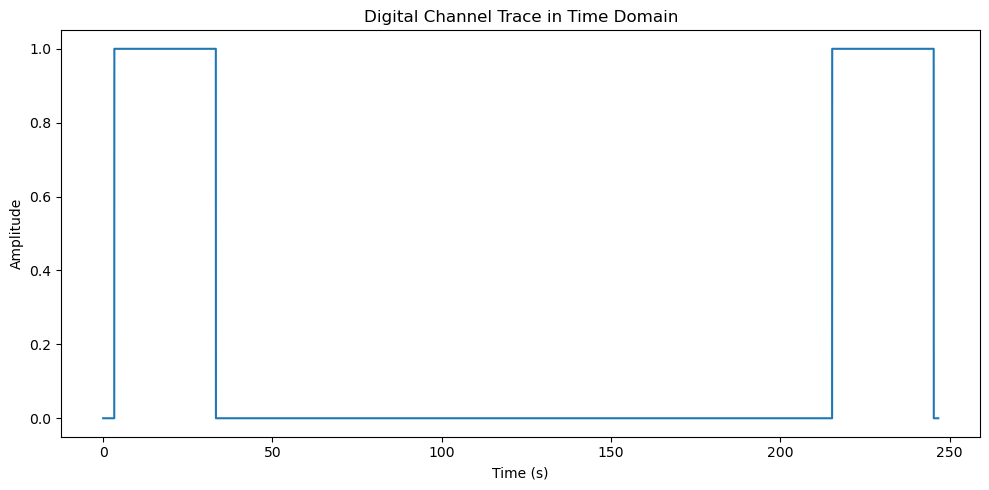

In [17]:
# Calculate the time vector
sampling_rate = 30000  # in Hz
num_samples = len(digital_trace_pre)
time_vector = np.arange(num_samples) / sampling_rate  # Time in seconds

# Plot the digital trace in the time domain
plt.figure(figsize=(10, 5))
plt.plot(time_vector, digital_trace_pre)
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('Digital Channel Trace in Time Domain')
plt.tight_layout()
plt.show()


In [18]:
# # Calculate the time vector
# sampling_rate = 30000  # in Hz
# num_samples = len(digital_trace_post)
# time_vector = np.arange(num_samples) / sampling_rate  # Time in seconds

# # Plot the digital trace in the time domain
# plt.figure(figsize=(10, 5))
# plt.plot(time_vector, digital_trace_post)
# plt.xlabel('Time (s)')
# plt.ylabel('Amplitude')
# plt.title('Digital Channel Trace in Time Domain')
# plt.tight_layout()
# plt.show()

# Extract windows of time where Von Frey stimulus is applied, calculate average stimulus and ECAP

Adjusted Time Windows:
[[  3.44323333   6.317     ]
 [  9.14863333  10.75973333]
 [ 13.50113333  15.51783333]
 [ 17.8995      20.3437    ]
 [ 23.67276667  25.48466667]
 [ 28.35686667  30.74856667]
 [ 34.0646      34.54696667]
 [218.8211     220.3361    ]
 [222.4159     223.9419    ]
 [226.13156667 228.84956667]
 [231.62366667 233.51886667]
 [236.51533333 238.7449    ]
 [241.2018     242.7427    ]
 [244.44093333 245.9065    ]]
Average Von Frey responses during adjusted intervals:
[522060.53 570568.   556760.25 655580.56 545050.44 777930.56 241632.72
 542330.25 525990.9  549662.   564767.4  618206.56 643666.56 491944.5 ]
Average recording responses during adjusted intervals (per channel):
[[-4.57795410e+01 -4.85429420e+01 -4.07891541e+01 -5.11449890e+01
  -5.55564346e+01 -5.97902412e+01 -6.72629929e+01 -9.19683762e+01
  -7.55866089e+01 -5.73168831e+01 -2.84160271e+01 -2.96652527e+01
  -3.27746468e+01 -2.11204147e+01 -2.49852867e+01 -1.80151405e+01
  -2.34457645e+01 -1.87551403e+01 -1.978

C:\Users\KarlJ\AppData\Roaming\Python\Python39\site-packages\IPython\core\pylabtools.py:152: UserWarning:

Creating legend with loc="best" can be slow with large amounts of data.



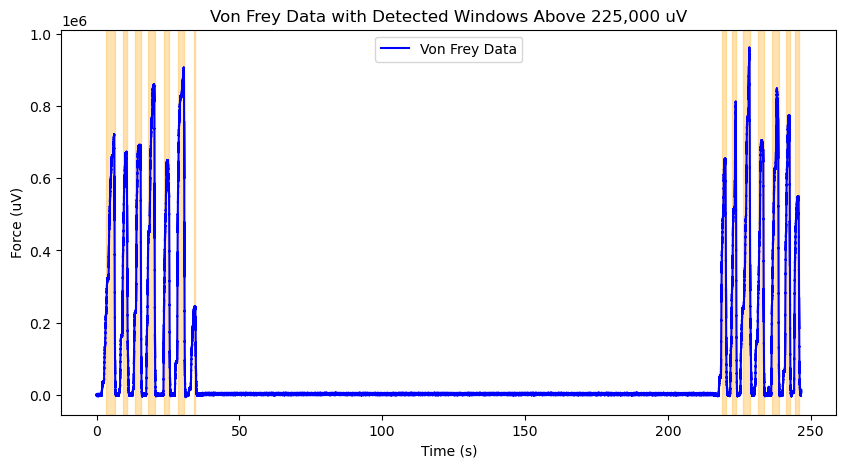

In [19]:
import numpy as np
import matplotlib.pyplot as plt

# Extract Von Frey data (assuming 'ANALOG-IN-2' is the correct channel)
von_frey_data = von_frey_pre.get_traces(channel_ids=['ANALOG-IN-2'], return_scaled=True).flatten()

# Sampling rate of the recording
sampling_rate = 30000  # Hz


#
#
# setting an amplitue threshold
#
#
# Set an amplitude threshold to identify crossings
amplitude_threshold = 225000  # Set to 250,000 microvolts

# Find indices where the von_frey_data crosses above the threshold (rising edge)
rising_edges = np.where((von_frey_data[:-1] < amplitude_threshold) & (von_frey_data[1:] >= amplitude_threshold))[0] + 1

# Find indices where the von_frey_data crosses below the threshold (falling edge)
falling_edges = np.where((von_frey_data[:-1] >= amplitude_threshold) & (von_frey_data[1:] < amplitude_threshold))[0] + 1

# Handle cases where the trace starts above the threshold
if von_frey_data[0] >= amplitude_threshold:
    rising_edges = np.insert(rising_edges, 0, 0)

# Handle cases where the trace ends above the threshold
if von_frey_data[-1] >= amplitude_threshold:
    falling_edges = np.append(falling_edges, len(von_frey_data) - 1)

# Ensure that the number of rising and falling edges matches
if len(rising_edges) > len(falling_edges):
    rising_edges = rising_edges[:len(falling_edges)]
elif len(falling_edges) > len(rising_edges):
    falling_edges = falling_edges[:len(rising_edges)]

# Define the time windows based on these edges
start_times = rising_edges / sampling_rate
end_times = falling_edges / sampling_rate

# Define buffers in seconds (optional)
start_buffer = 0.1  # Time to add to the start of each interval
end_buffer = 0.05   # Time to subtract from the end of each interval

# Adjust the time windows with buffers
adjusted_start_times = start_times + start_buffer
adjusted_end_times = end_times - end_buffer

# Ensure that the adjusted times are within valid bounds
valid_indices = adjusted_start_times < adjusted_end_times

# Apply the valid indices to filter out any invalid intervals
adjusted_start_times = adjusted_start_times[valid_indices]
adjusted_end_times = adjusted_end_times[valid_indices]

# Convert adjusted times back to sample indices
adjusted_start_indices = (adjusted_start_times * sampling_rate).astype(int)
adjusted_end_indices = (adjusted_end_times * sampling_rate).astype(int)

# Ensure indices are within the valid range
num_samples = len(von_frey_data)
adjusted_start_indices = np.clip(adjusted_start_indices, 0, num_samples - 1)
adjusted_end_indices = np.clip(adjusted_end_indices, 0, num_samples - 1)

# Get recording data (all channels or specify channel_ids as needed)
recording_data = recording_pre.get_traces(return_scaled=True)

# Initialize lists to store averages
von_frey_averages = []
recording_averages = []

# Loop over each adjusted time window
for start_idx, end_idx in zip(adjusted_start_indices, adjusted_end_indices):
    # Extract data segments corresponding to the adjusted time window
    von_frey_segment = von_frey_data[start_idx:end_idx]
    recording_segment = recording_data[start_idx:end_idx, :]  # All channels during the time window

    # Compute averages
    von_frey_avg = np.mean(von_frey_segment)
    recording_avg = np.mean(recording_segment, axis=0)  # Average across time for each channel

    # Store the averages
    von_frey_averages.append(von_frey_avg)
    recording_averages.append(recording_avg)

# Convert lists to arrays for easier manipulation
von_frey_averages = np.array(von_frey_averages)
recording_averages = np.array(recording_averages)

# Now you have the average Von Frey and recording responses during the adjusted intervals
print("Adjusted Time Windows:")
print(np.column_stack((adjusted_start_times, adjusted_end_times)))

print("Average Von Frey responses during adjusted intervals:")
print(von_frey_averages)

print("Average recording responses during adjusted intervals (per channel):")
print(recording_averages)

# Optional: Plot the Von Frey data with the detected windows
time_vector = np.arange(len(von_frey_data)) / sampling_rate

plt.figure(figsize=(10, 5))
plt.plot(time_vector, von_frey_data, label='Von Frey Data', color='blue')
for start, end in zip(adjusted_start_times, adjusted_end_times):
    plt.axvspan(start, end, color='orange', alpha=0.3)

plt.xlabel('Time (s)')
plt.ylabel('Force (uV)')
plt.title('Von Frey Data with Detected Windows Above 225,000 uV')
plt.legend()
plt.show()


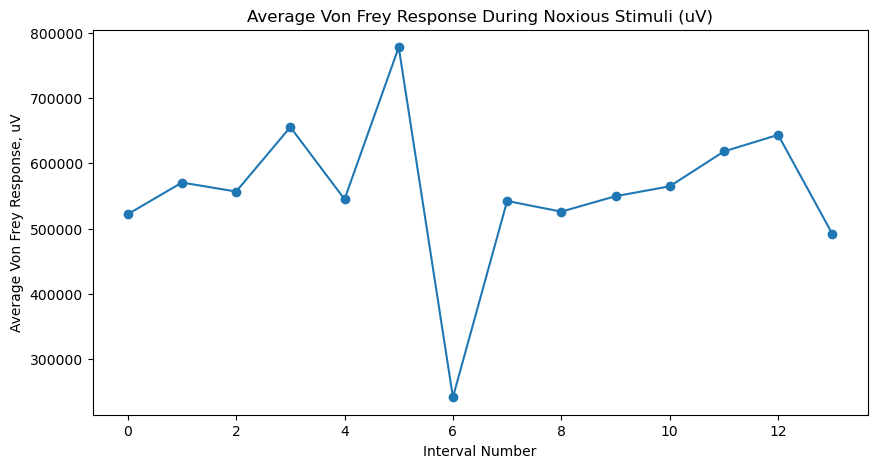

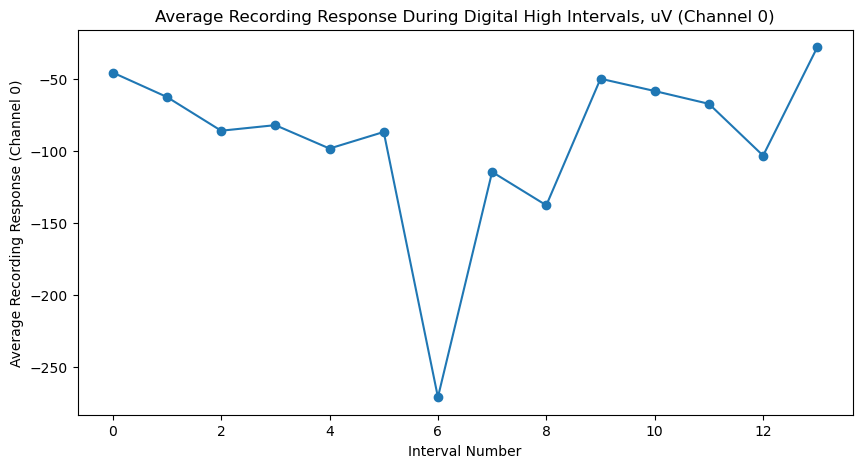

In [20]:
channel_number = 1  # Change to the channel you're interested in

# Plot the average Von Frey response during each interval
plt.figure(figsize=(10, 5))
plt.plot(von_frey_averages, marker='o')
plt.xlabel('Interval Number')
plt.ylabel('Average Von Frey Response, uV')
plt.title('Average Von Frey Response During Noxious Stimuli (uV)')
plt.show()

# Plot the average recording response for a specific channel (e.g., channel 0)
channel_number = 0  # Change to the channel you're interested in
plt.figure(figsize=(10, 5))
plt.plot(recording_averages[:, channel_number], marker='o')
plt.xlabel('Interval Number')
plt.ylabel(f'Average Recording Response (Channel {channel_number})')
plt.title(f'Average Recording Response During Digital High Intervals, uV (Channel {channel_number})')
plt.show()


# 🖼 Export Results to binary and run Kilosort trial summary

### run trial review

In [21]:
def my_custom_criteria(cluster_labels, st, clu, est_contam_rate, fs):
    # Example criteria: Contamination rate < 0.1 and firing rate between 0.5 and 50 Hz
    contam_good = est_contam_rate < 0.2
    fr_good = np.zeros(cluster_labels.size, dtype=bool)
    for i, c in enumerate(cluster_labels):
        spikes = st[clu == c]
        fr = spikes.size / ((spikes.max() - spikes.min()) / fs)
        if 0.5 <= fr <= 50:
            fr_good[i] = True
    return np.logical_and(contam_good, fr_good)

kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_10_241125_162725\DW327_VF_10_241125_162725_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------


Preparing Kilosort wrapper...
|
|
|
|
|
|
Running kilosort on VF_10_241125_162725
|
|
|
|
|
|


kilosort.run_kilosort: N samples: 2100000
kilosort.run_kilosort: N seconds: 70.0
kilosort.run_kilosort: N batches: 2
kilosort.run_kilosort: Preprocessing filters computed in  6.74s; total  6.74s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    24.00 %
kilosort.run_kilosort: Memory:       97.98 %     |     46.96   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   55.99 %     |      4.48   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    31.69 %     |      2.54   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing

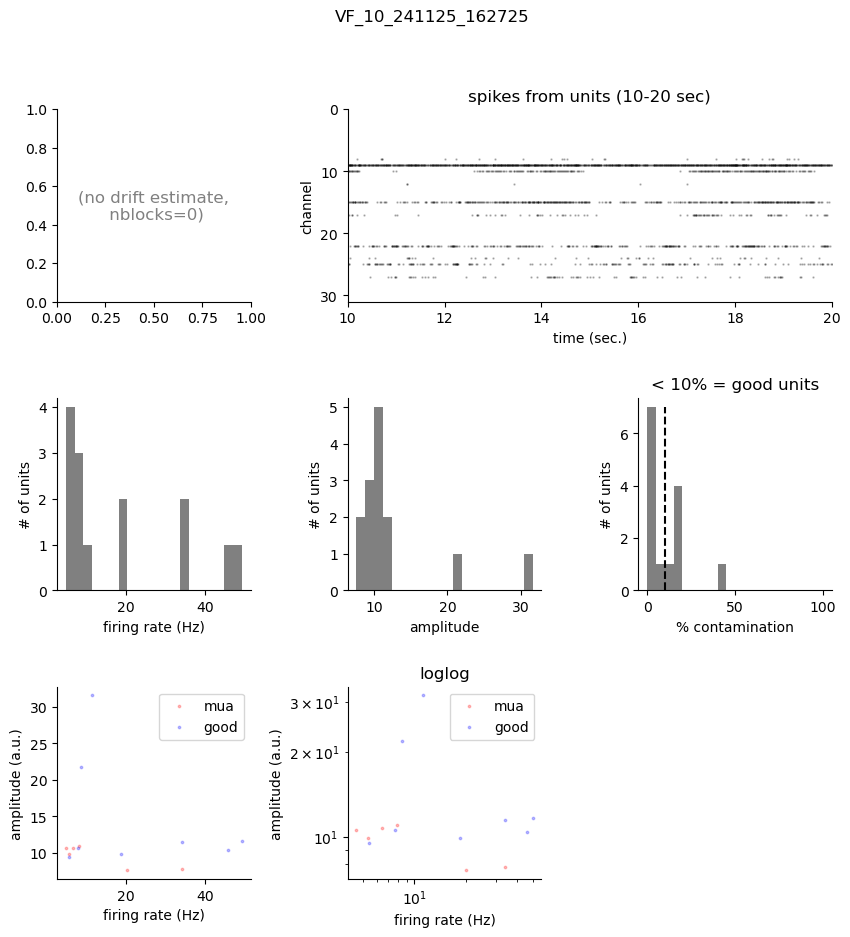

ERROR: could not plot units for VF_10_241125_162725, good. skipping plot...
ERROR: could not plot units for VF_10_241125_162725, mua. skipping plot...


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_1_241125_153746\DW327_VF_1_241125_153746_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

Custom labels applied and saved for trial: VF_10_241125_162725
|
|
|
|
|
|
Running kilosort on VF_1_241125_153746
|
|
|
|
|
|


kilosort.run_kilosort: Preprocessing filters computed in  5.46s; total  5.48s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    41.80 %
kilosort.run_kilosort: Memory:       98.51 %     |     47.22   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   100.00 %     |      8.00   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    50.47 %     |      4.04   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, 

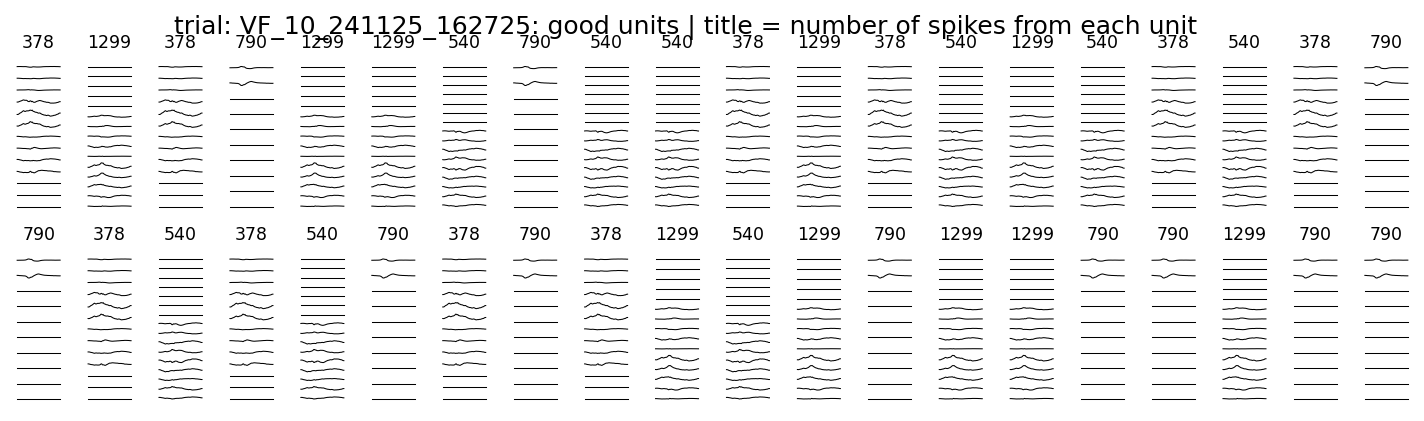

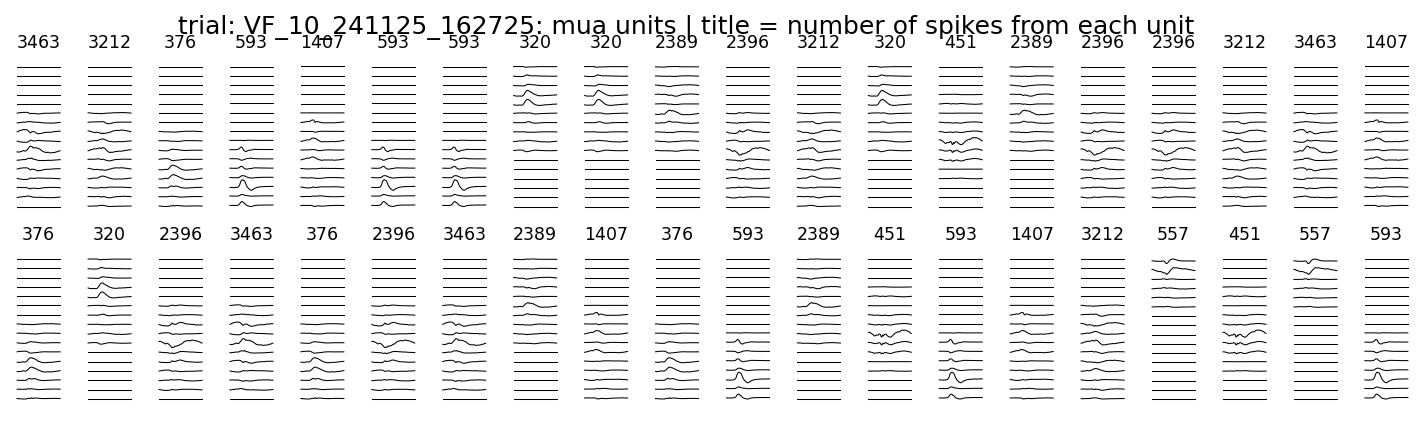

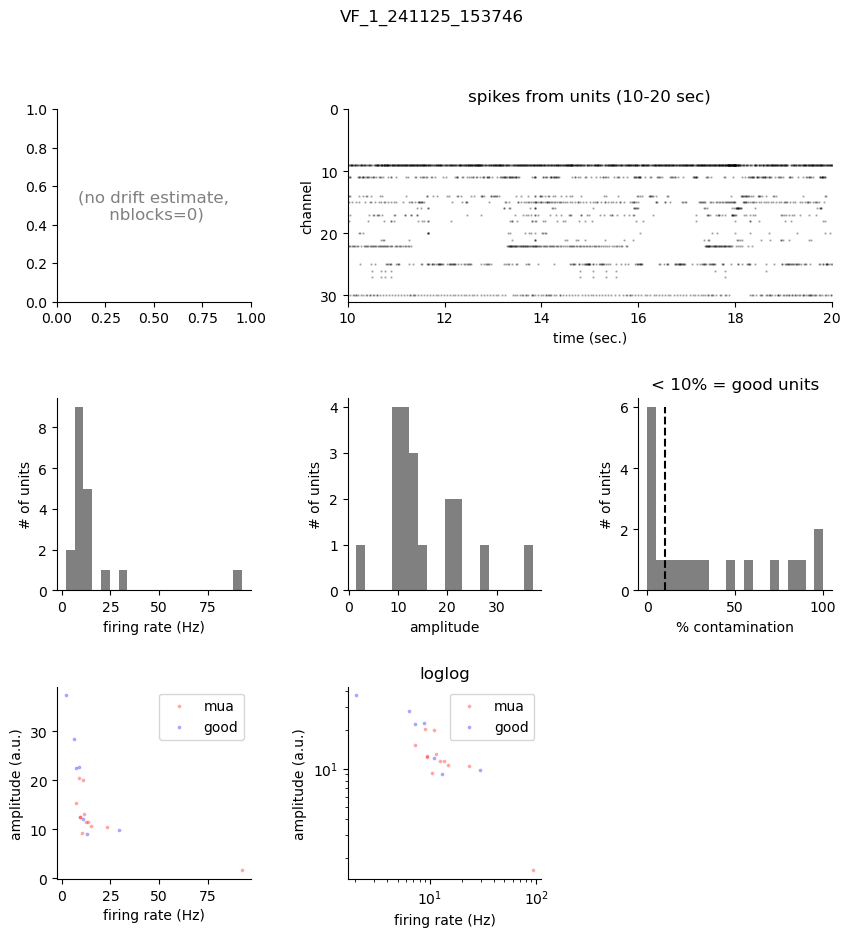

ERROR: could not plot units for VF_1_241125_153746, good. skipping plot...
ERROR: could not plot units for VF_1_241125_153746, mua. skipping plot...


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_2_241125_154307\DW327_VF_2_241125_154307_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

Custom labels applied and saved for trial: VF_1_241125_153746
|
|
|
|
|
|
Running kilosort on VF_2_241125_154307
|
|
|
|
|
|


kilosort.run_kilosort: Preprocessing filters computed in  5.03s; total  5.03s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    43.40 %
kilosort.run_kilosort: Memory:       97.65 %     |     46.81   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   100.00 %     |      8.00   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    50.49 %     |      4.04   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, 

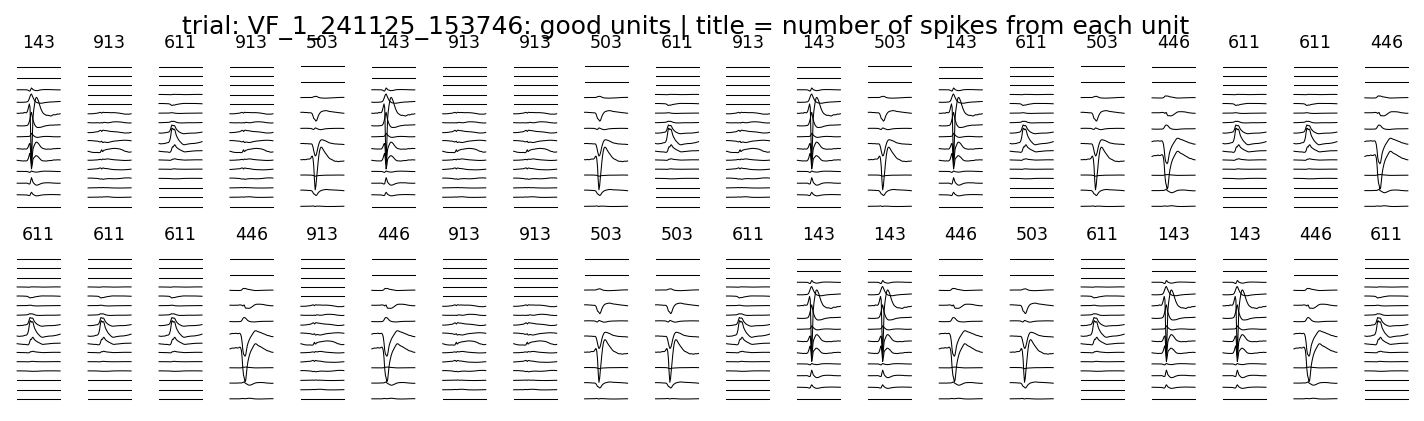

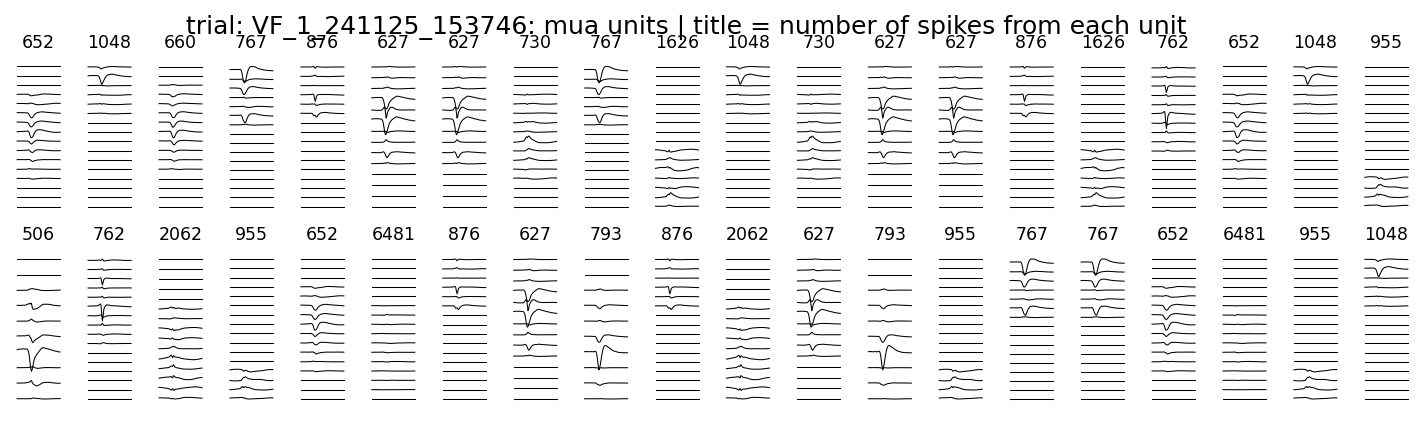

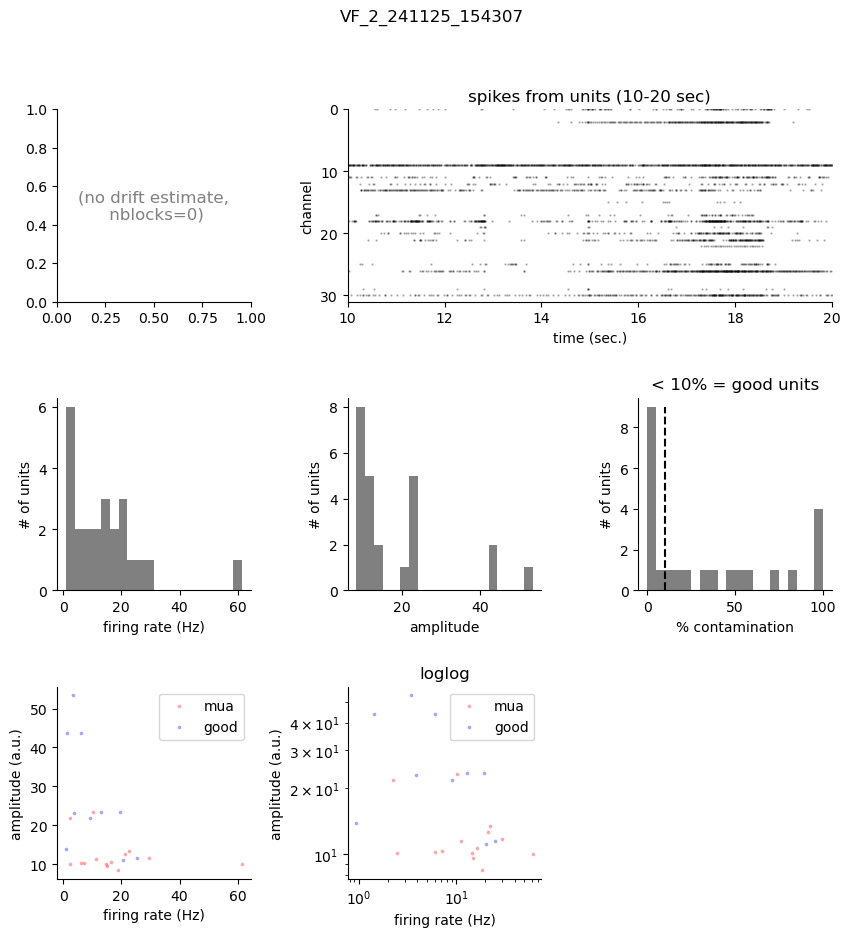

ERROR: could not plot units for VF_2_241125_154307, good. skipping plot...
ERROR: could not plot units for VF_2_241125_154307, mua. skipping plot...


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_3_241125_154841\DW327_VF_3_241125_154841_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

Custom labels applied and saved for trial: VF_2_241125_154307
|
|
|
|
|
|
Running kilosort on VF_3_241125_154841
|
|
|
|
|
|


kilosort.run_kilosort: Preprocessing filters computed in  11.17s; total  11.17s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    40.70 %
kilosort.run_kilosort: Memory:       98.57 %     |     47.25   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   100.00 %     |      8.00   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    50.51 %     |      4.04   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0

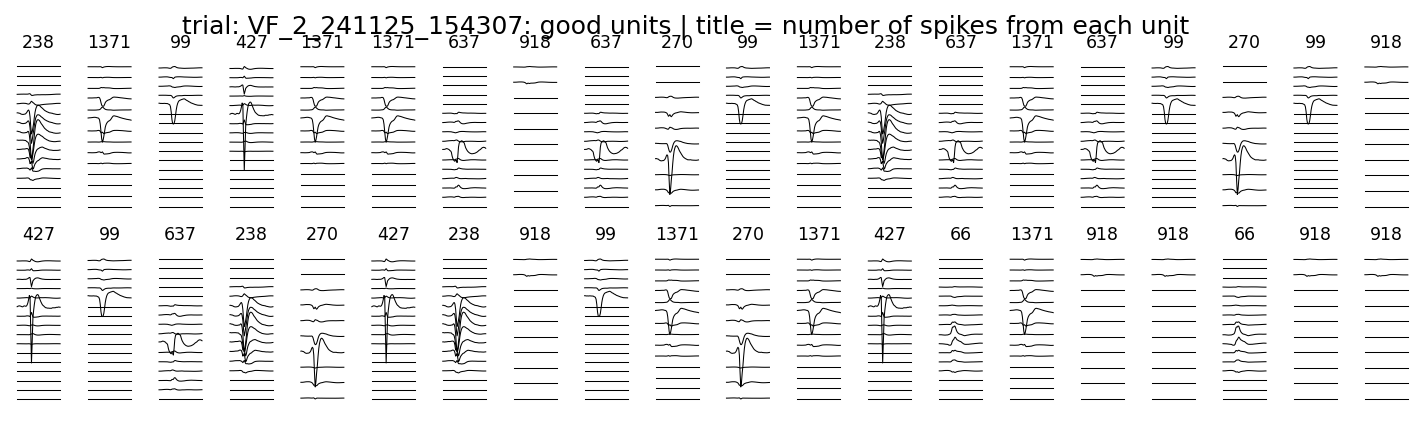

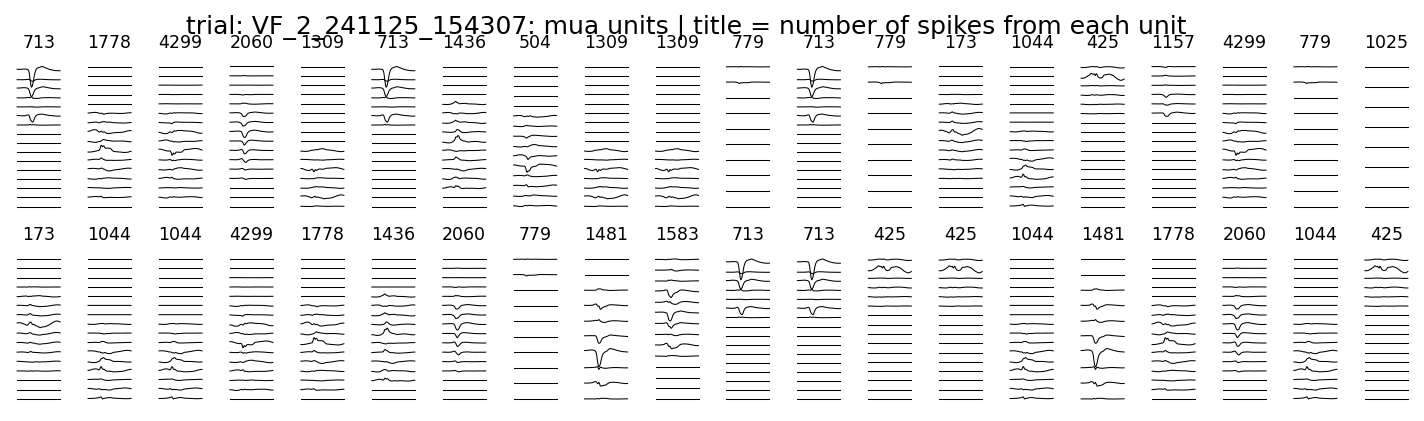

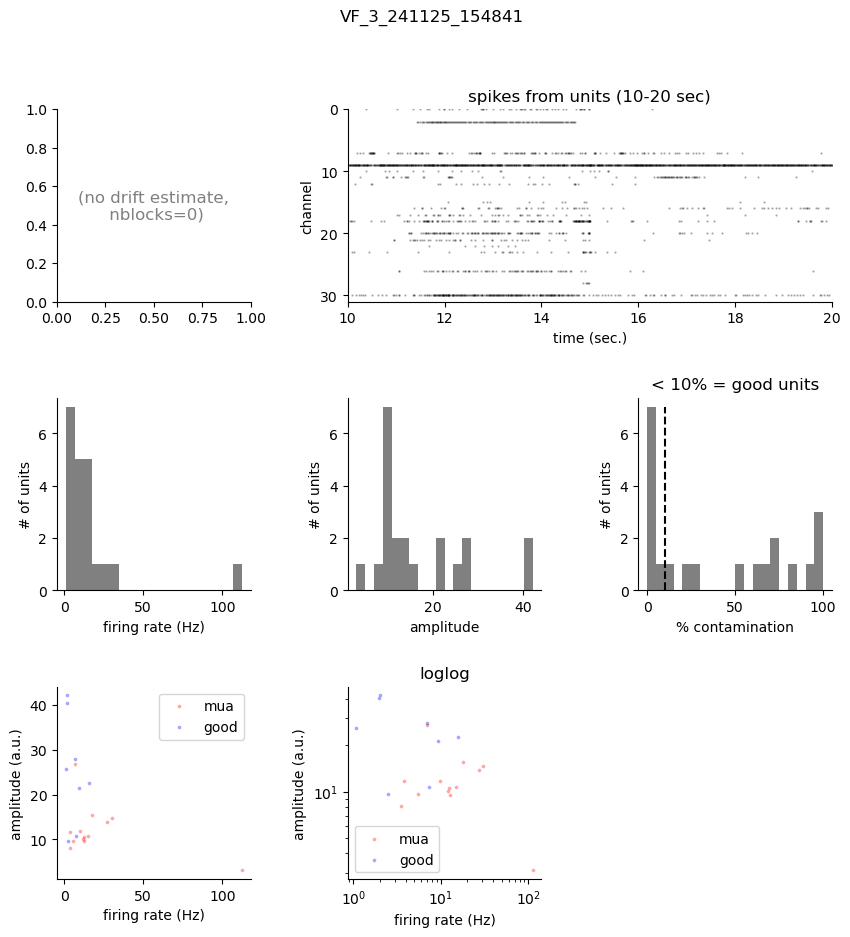

ERROR: could not plot units for VF_3_241125_154841, good. skipping plot...
ERROR: could not plot units for VF_3_241125_154841, mua. skipping plot...


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_4_241125_155417\DW327_VF_4_241125_155417_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

Custom labels applied and saved for trial: VF_3_241125_154841
|
|
|
|
|
|
Running kilosort on VF_4_241125_155417
|
|
|
|
|
|


kilosort.run_kilosort: Preprocessing filters computed in  0.89s; total  0.89s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    44.30 %
kilosort.run_kilosort: Memory:       98.64 %     |     47.28   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   100.00 %     |      8.00   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    50.51 %     |      4.04   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, 

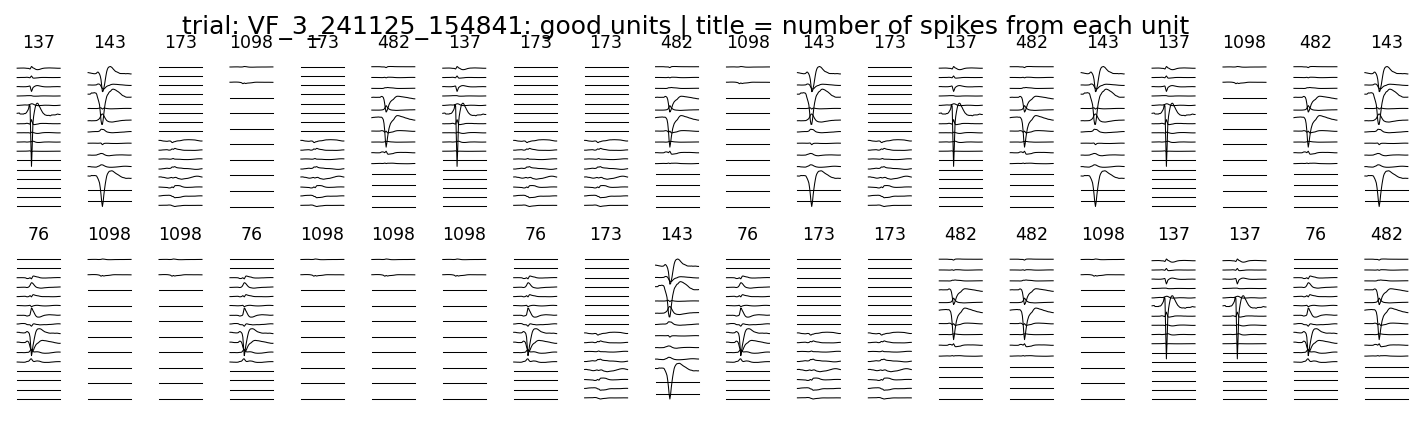

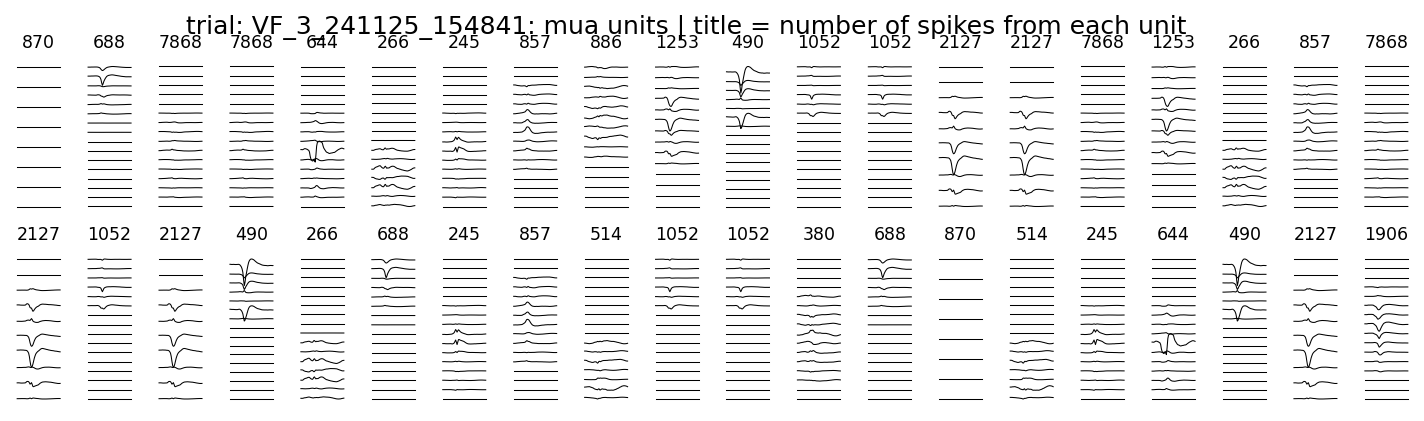

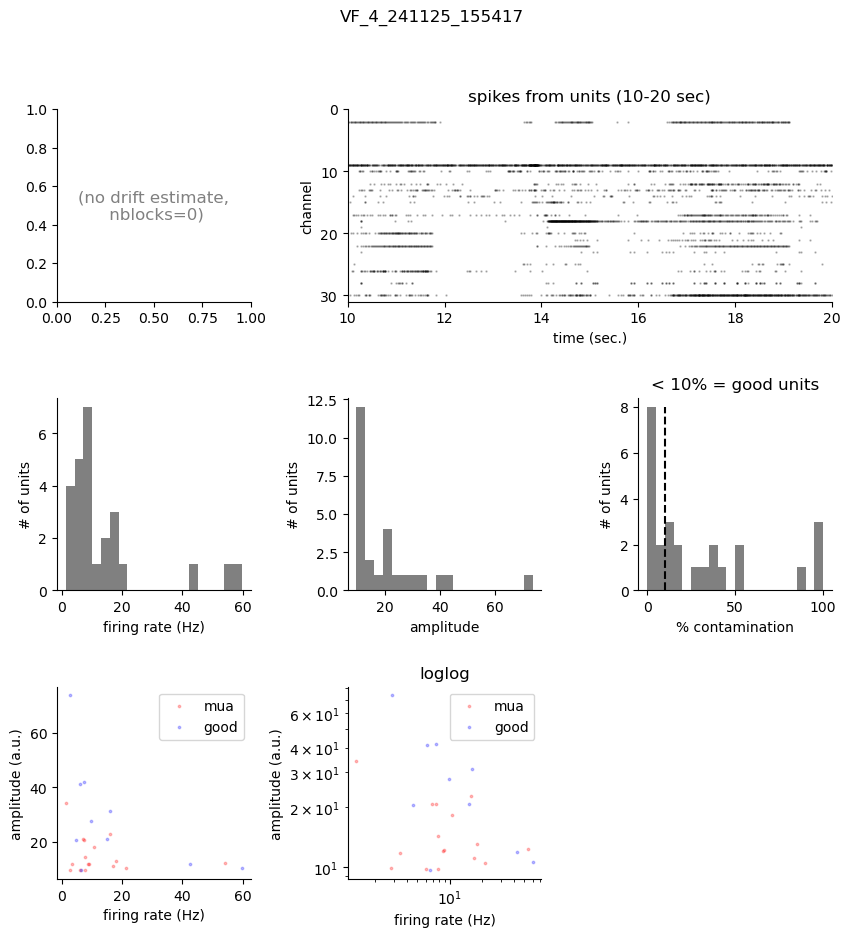

ERROR: could not plot units for VF_4_241125_155417, good. skipping plot...
ERROR: could not plot units for VF_4_241125_155417, mua. skipping plot...
Custom labels applied and saved for trial: VF_4_241125_155417
|
|
|
|
|
|
Running kilosort on VF_5_241125_155941
|
|
|
|
|
|


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_5_241125_155941\DW327_VF_5_241125_155941_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

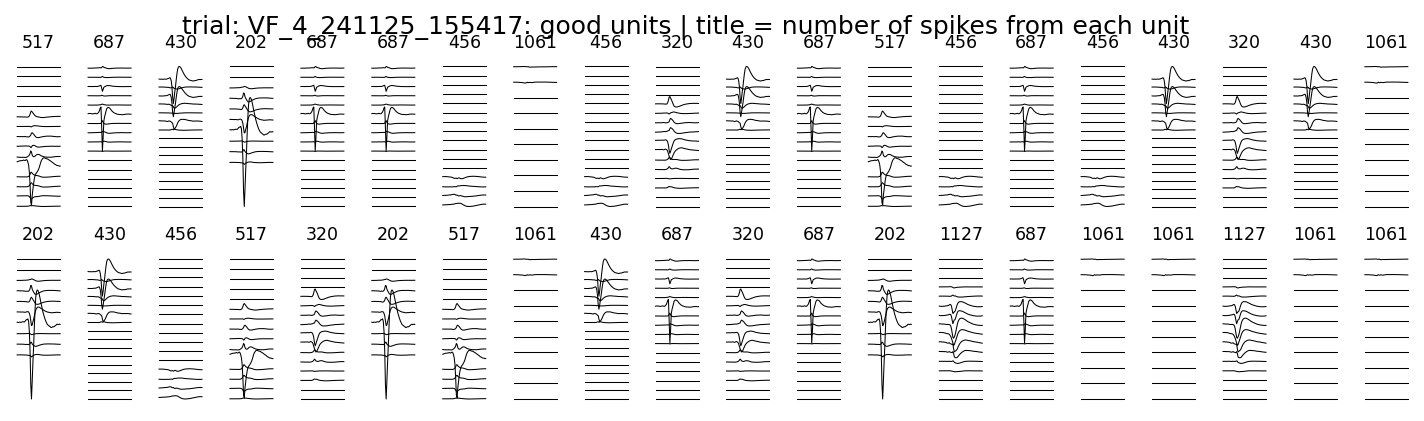

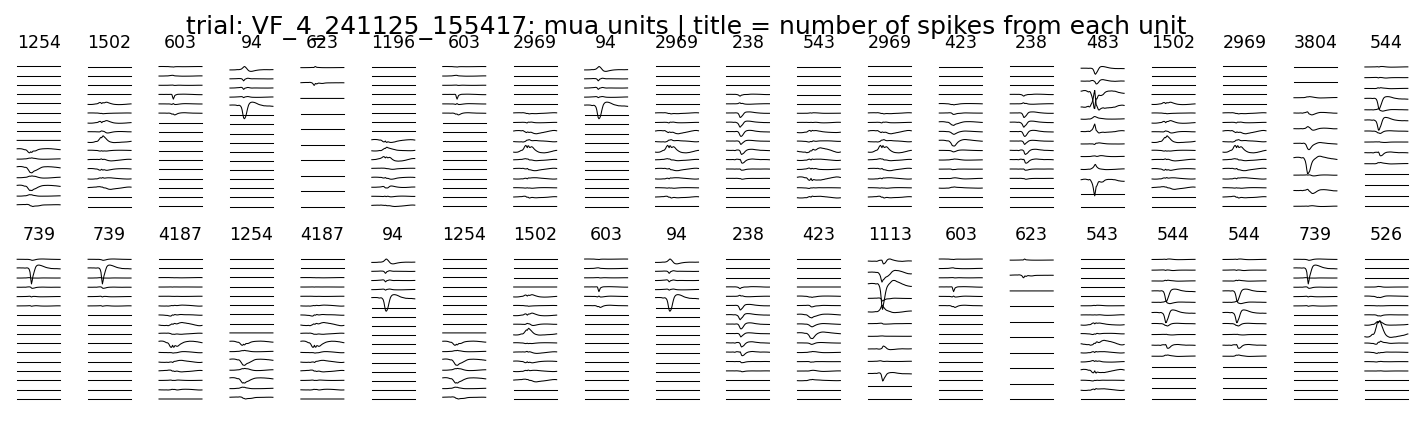

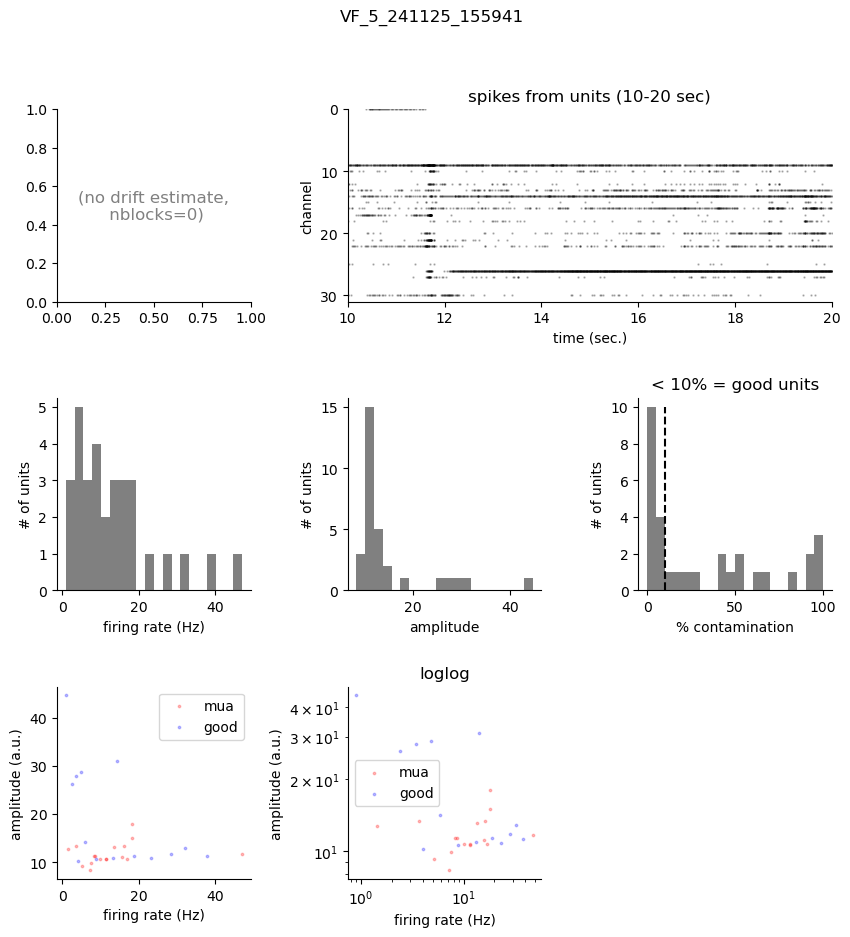

ERROR: could not plot units for VF_5_241125_155941, good. skipping plot...


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_6_241125_160515\DW327_VF_6_241125_160515_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

ERROR: could not plot units for VF_5_241125_155941, mua. skipping plot...
Custom labels applied and saved for trial: VF_5_241125_155941
|
|
|
|
|
|
Running kilosort on VF_6_241125_160515
|
|
|
|
|
|


kilosort.run_kilosort: Preprocessing filters computed in  0.80s; total  0.80s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    31.70 %
kilosort.run_kilosort: Memory:       97.68 %     |     46.82   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   100.00 %     |      8.00   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    50.61 %     |      4.05   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, 

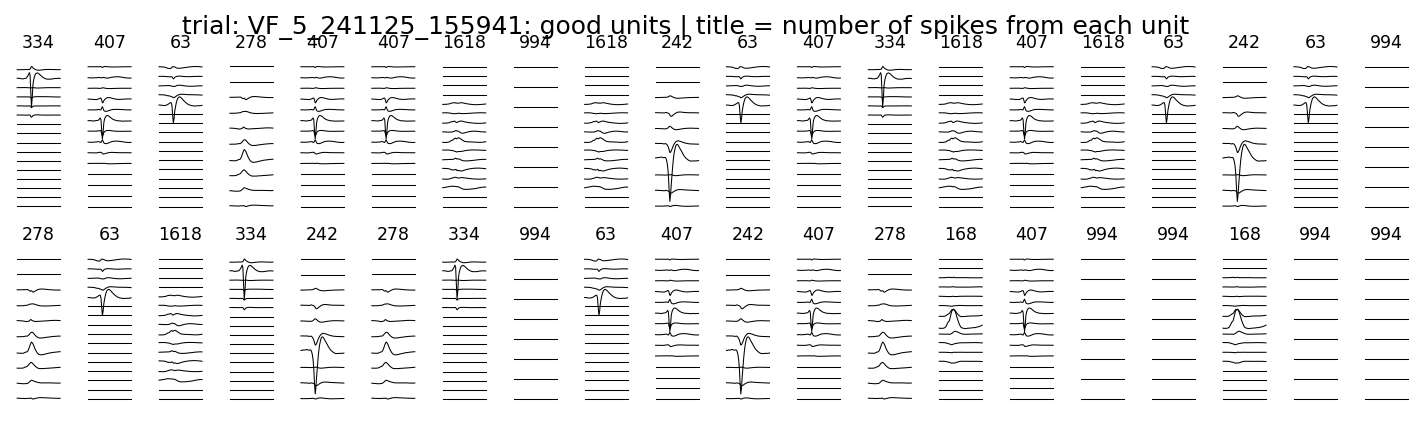

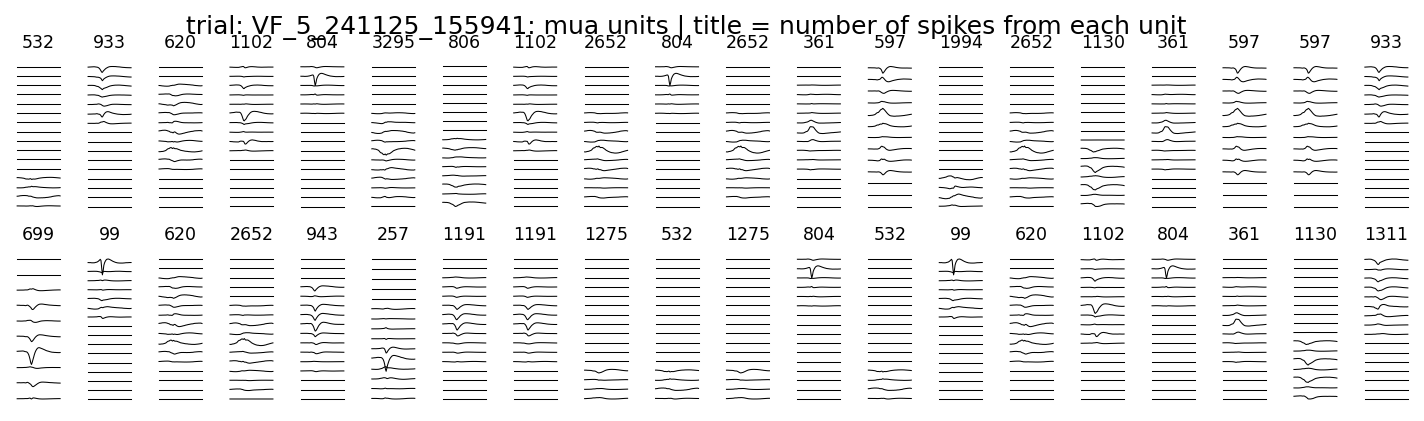

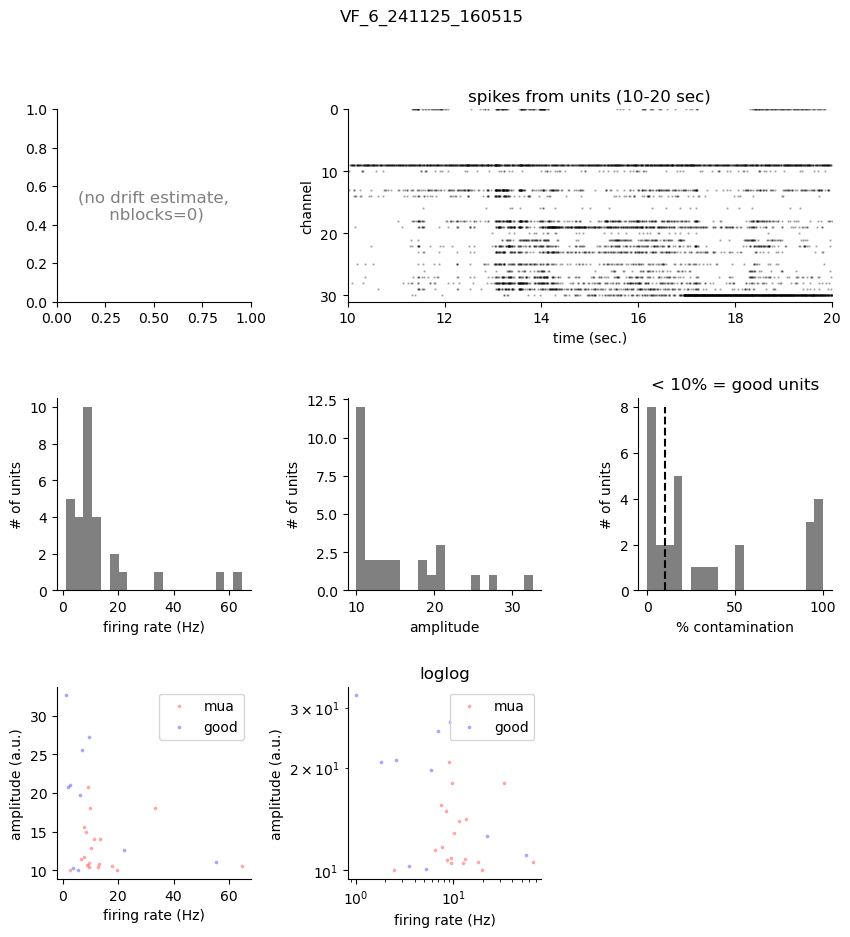

ERROR: could not plot units for VF_6_241125_160515, good. skipping plot...


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_7_241125_161126\DW327_VF_7_241125_161126_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

ERROR: could not plot units for VF_6_241125_160515, mua. skipping plot...
Custom labels applied and saved for trial: VF_6_241125_160515
|
|
|
|
|
|
Running kilosort on VF_7_241125_161126
|
|
|
|
|
|


kilosort.run_kilosort: Preprocessing filters computed in  3.80s; total  3.80s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    35.80 %
kilosort.run_kilosort: Memory:       99.67 %     |     47.78   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   100.00 %     |      8.00   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    50.61 %     |      4.05   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, 

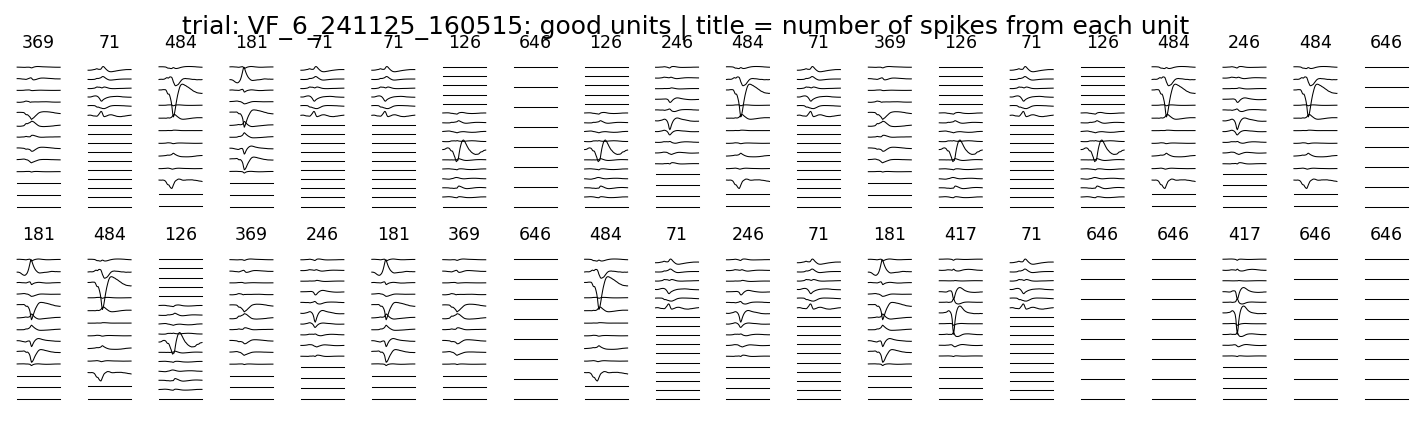

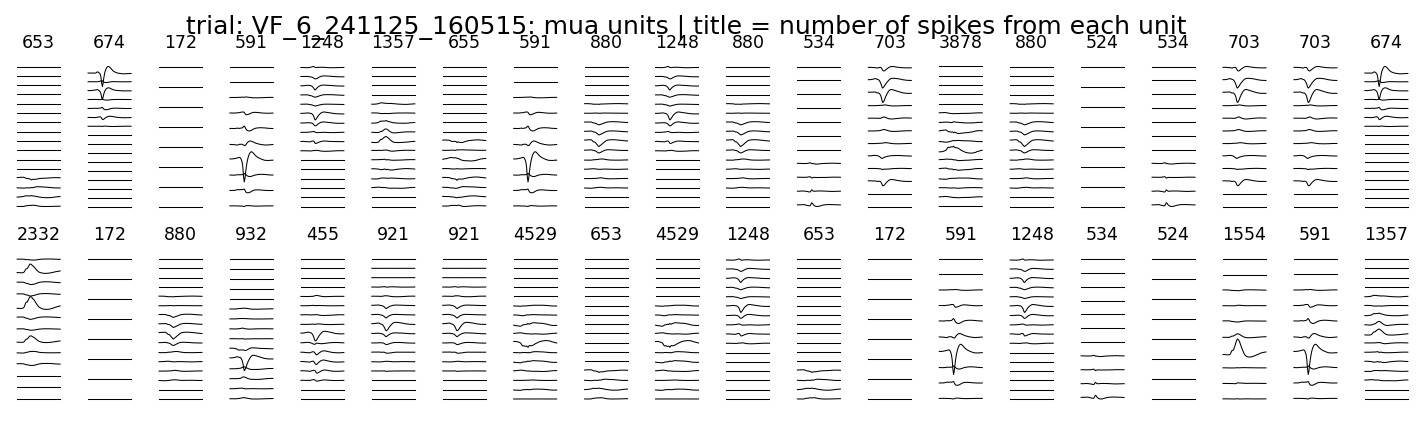

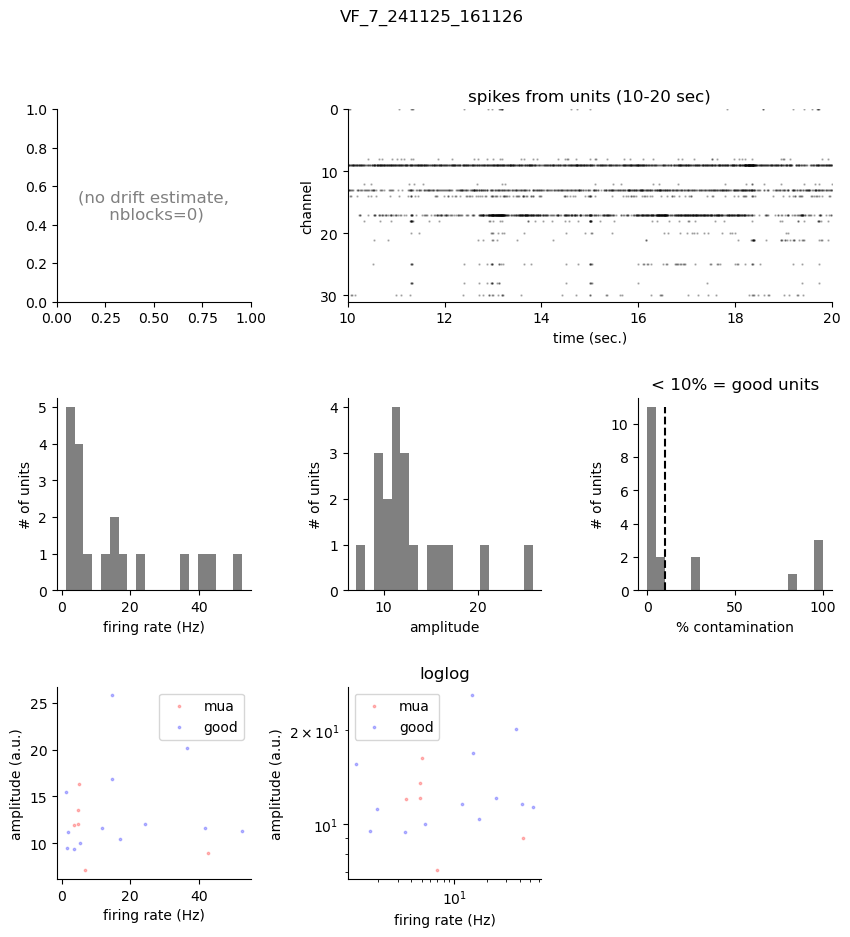

ERROR: could not plot units for VF_7_241125_161126, good. skipping plot...


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_8_241125_161626\DW327_VF_8_241125_161626_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

ERROR: could not plot units for VF_7_241125_161126, mua. skipping plot...
Custom labels applied and saved for trial: VF_7_241125_161126
|
|
|
|
|
|
Running kilosort on VF_8_241125_161626
|
|
|
|
|
|


kilosort.run_kilosort: Preprocessing filters computed in  0.88s; total  0.89s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    33.10 %
kilosort.run_kilosort: Memory:       97.19 %     |     46.59   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   100.00 %     |      8.00   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    50.61 %     |      4.05   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, 

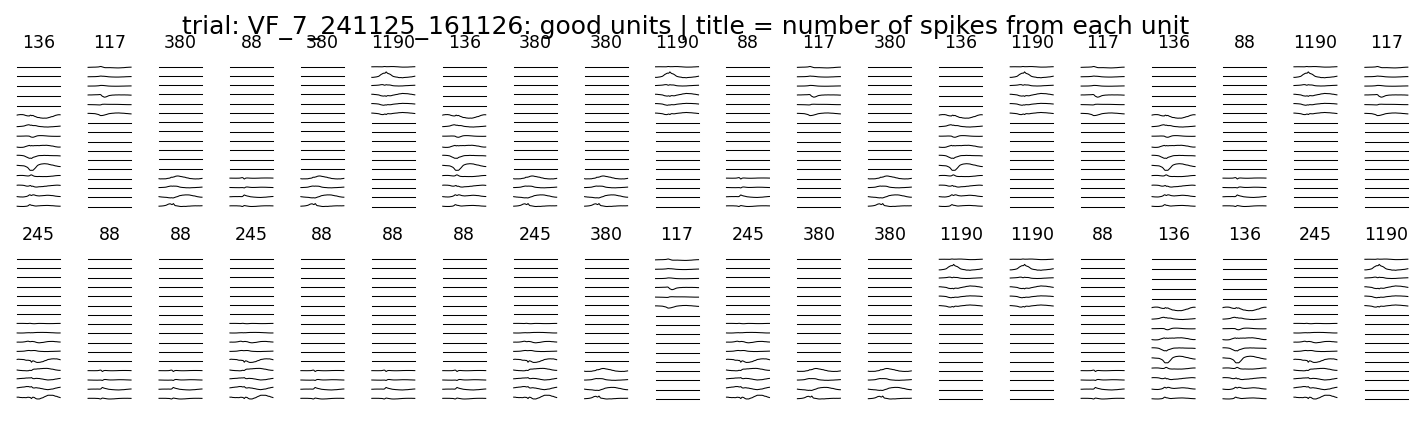

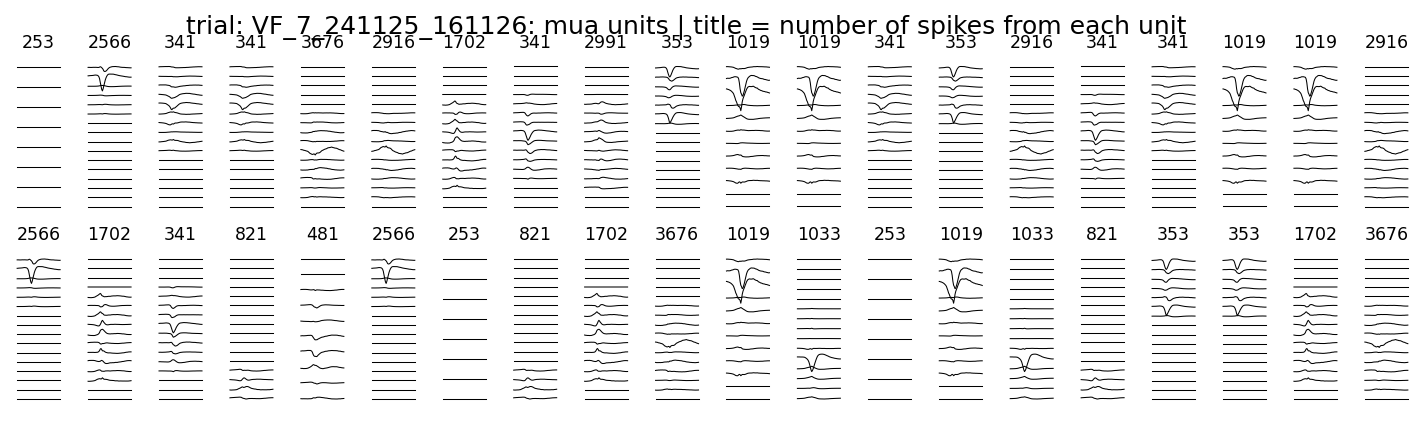

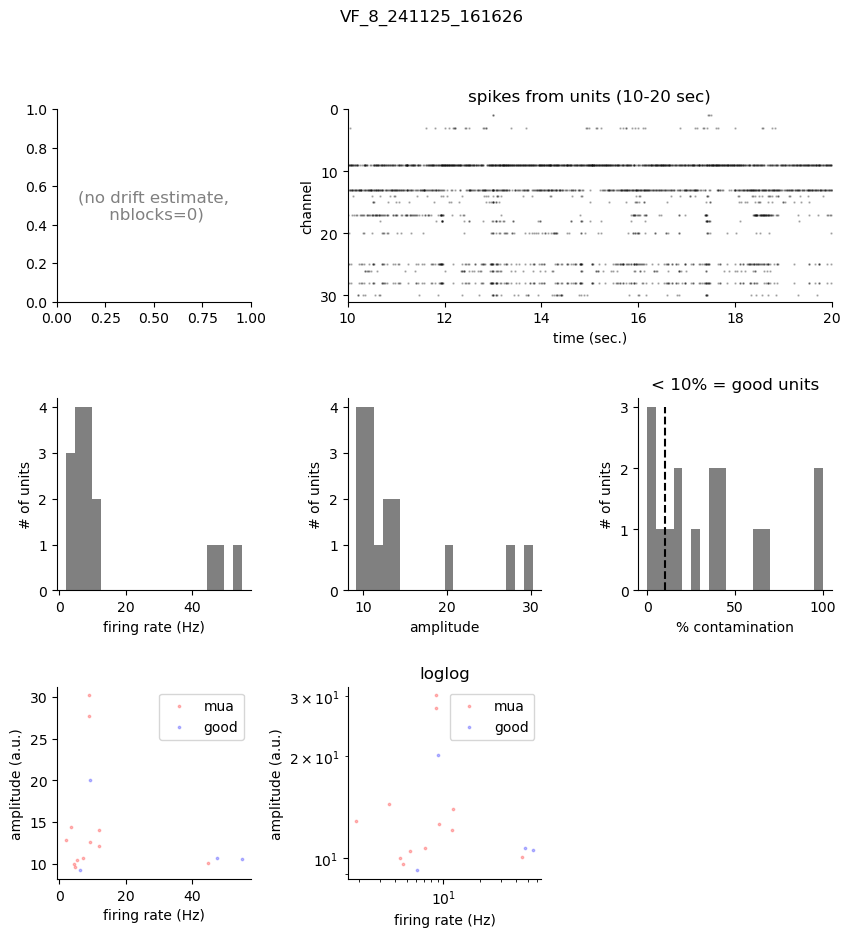

ERROR: could not plot units for VF_8_241125_161626, good. skipping plot...
ERROR: could not plot units for VF_8_241125_161626, mua. skipping plot...
Custom labels applied and saved for trial: VF_8_241125_161626


kilosort.run_kilosort: Kilosort version 4.0.20
kilosort.run_kilosort: Python version 3.9.20
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: System information:
kilosort.run_kilosort: Windows-10-10.0.19045-SP0 AMD64
kilosort.run_kilosort: AMD64 Family 23 Model 1 Stepping 1, AuthenticAMD
kilosort.run_kilosort: Using GPU for PyTorch computations. Specify `device` to change this.
kilosort.run_kilosort: Using CUDA device: NVIDIA GeForce GTX 1070 8.00GB
kilosort.run_kilosort: ----------------------------------------
kilosort.run_kilosort: Sorting D:\Data\CMU.80 Data\88 Analyzed Data\88.006 Von Vrey Analysis\DW327\binary\VF_9_241125_162141\DW327_VF_9_241125_162141_data.bin
kilosort.run_kilosort: Interpreting binary file as default dtype='int16'. If data was saved in a different format, specify `data_dtype`.
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing preprocessing variables.
kilosort.run_kilosort: ----------------------------------------
ki

|
|
|
|
|
|
Running kilosort on VF_9_241125_162141
|
|
|
|
|
|


kilosort.run_kilosort: Preprocessing filters computed in  1.43s; total  1.44s
kilosort.run_kilosort:  
kilosort.run_kilosort: Resource usage after preprocessing
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort: CPU usage:    30.80 %
kilosort.run_kilosort: Memory:       96.54 %     |     46.27   /    47.93 GB
kilosort.run_kilosort: ------------------------------------------------------
kilosort.run_kilosort: GPU usage:    `conda install pynvml` for GPU usage
kilosort.run_kilosort: GPU memory:   100.00 %     |      8.00   /     8.00 GB
kilosort.run_kilosort: Allocated:     0.10 %     |      0.01   /     8.00 GB
kilosort.run_kilosort: Max alloc:    50.61 %     |      4.05   /     8.00 GB
kilosort.run_kilosort: ********************************************************
kilosort.run_kilosort:  
kilosort.run_kilosort: Computing drift correction.
kilosort.run_kilosort: ----------------------------------------
kilosort.datashift: nblocks = 0, 

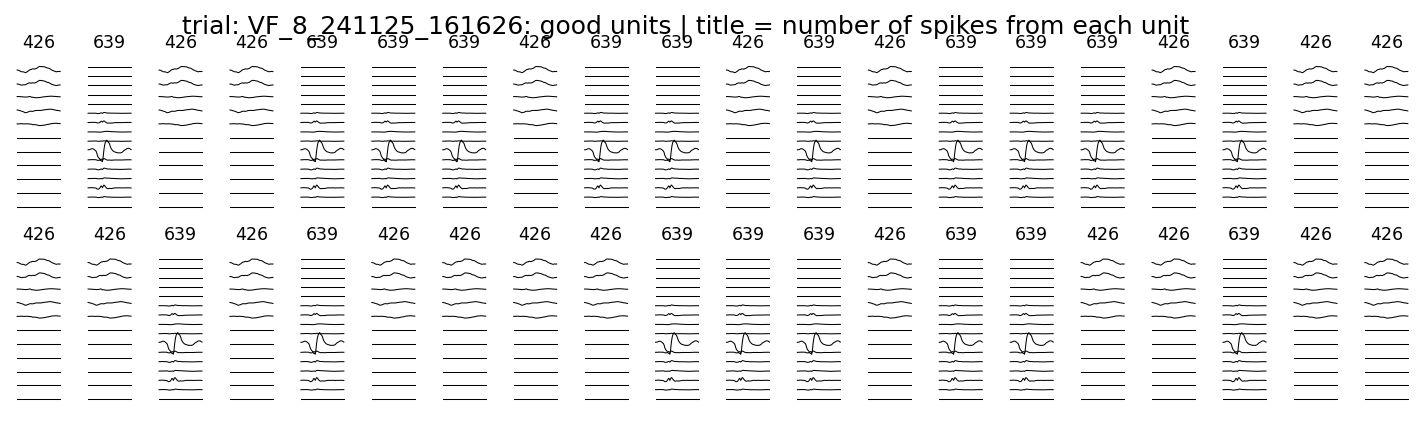

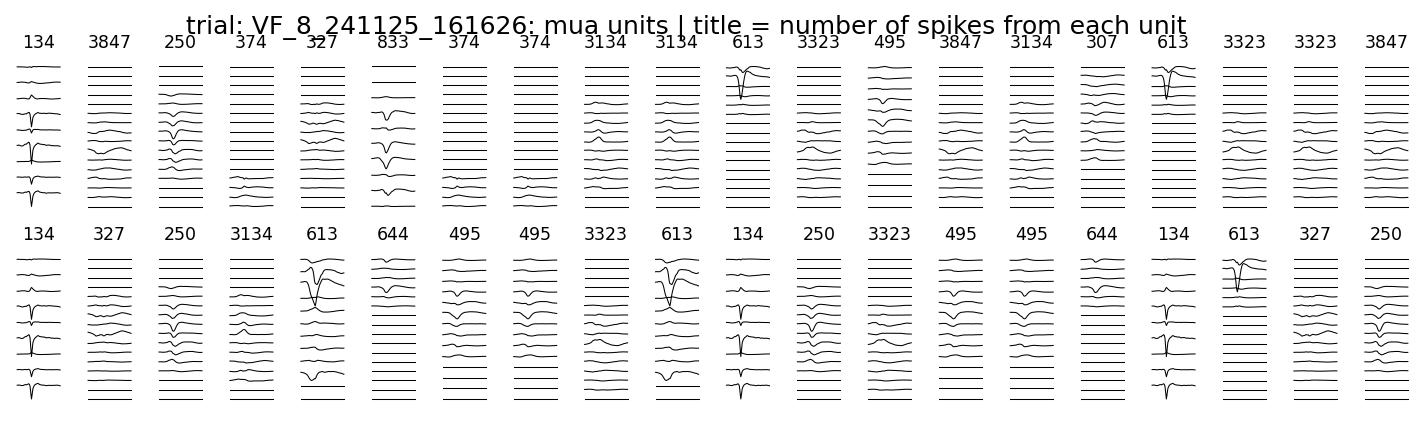

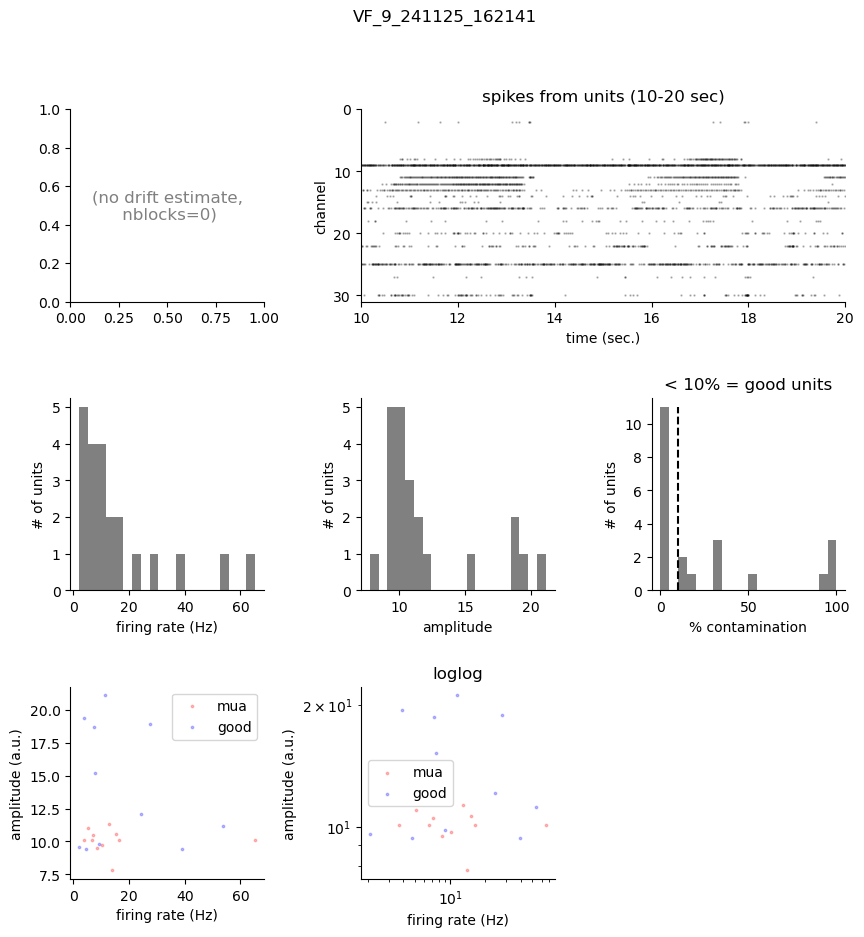

ERROR: could not plot units for VF_9_241125_162141, good. skipping plot...
ERROR: could not plot units for VF_9_241125_162141, mua. skipping plot...
Custom labels applied and saved for trial: VF_9_241125_162141


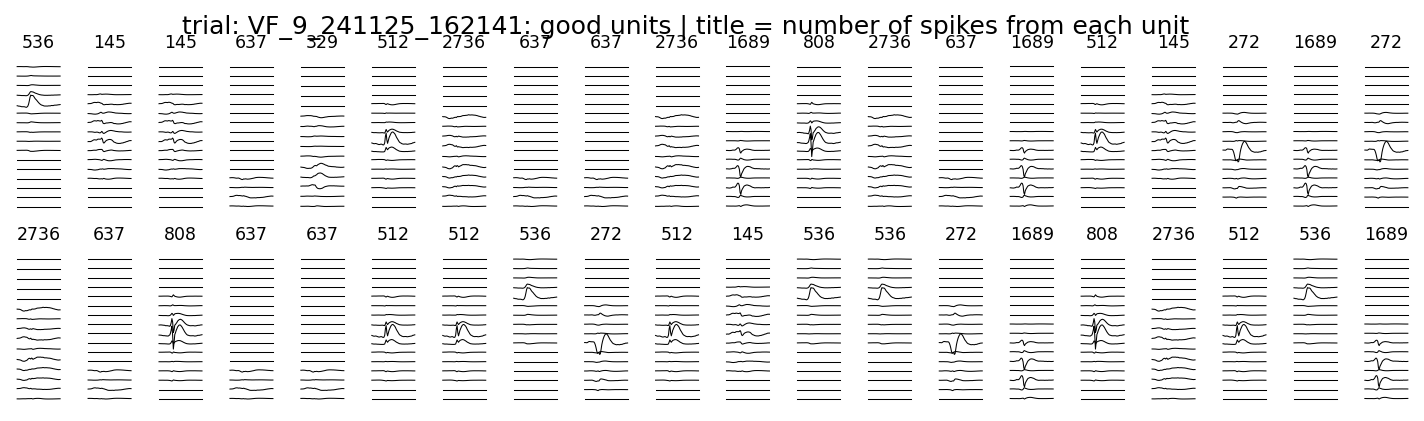

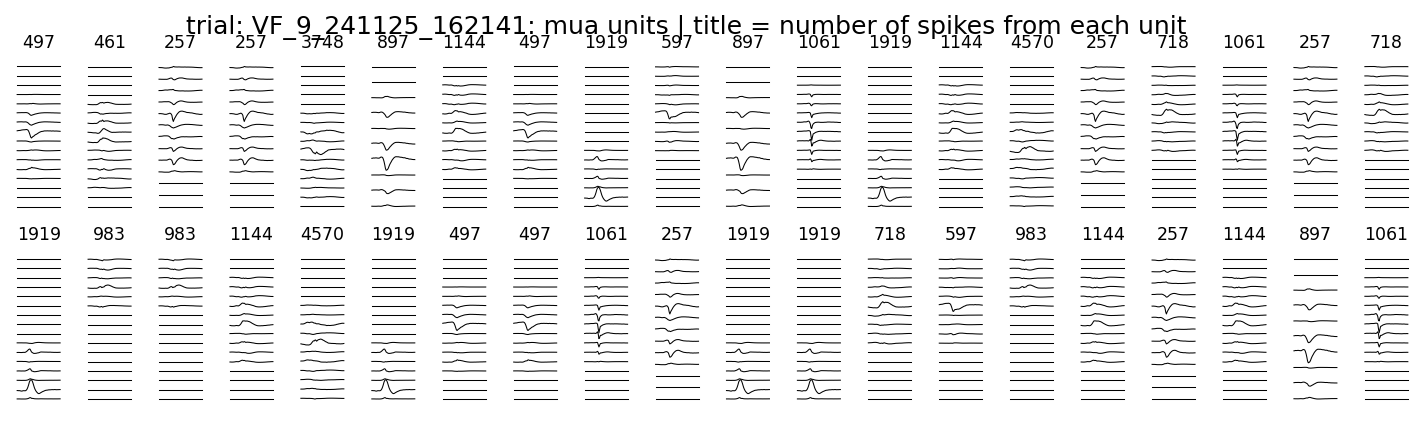

In [22]:
# # signals.save_spinalcord_data_to_binary(TRIAL_NAMES=["VF_8_241125_161626",
# # #                                                      ])
# signals.save_spinalcord_data_to_binary()

spikes = Kilosort_wrapper(SAVE_DIRECTORY, PROBE_DIRECTORY)

# # NOTE: running the trial summary will take some time. I've commented it out. if you need to generate kilosort outputs, then uncomment
# spikes.run_kilosort_trial_summary()

# Run Kilosort and apply custom labels with your custom criteria
spikes.run_kilosort_trial_summary(new_settings="vf_settings",custom_criteria=my_custom_criteria)


### import results from kilosort to run further analysis

In [23]:
spikes.extract_kilosort_outputs()

Kilosort outputs successfully loaded for trial: VF_10_241125_162725
Kilosort outputs successfully loaded for trial: VF_1_241125_153746
Kilosort outputs successfully loaded for trial: VF_2_241125_154307
Kilosort outputs successfully loaded for trial: VF_3_241125_154841
Kilosort outputs successfully loaded for trial: VF_4_241125_155417
Kilosort outputs successfully loaded for trial: VF_5_241125_155941
Kilosort outputs successfully loaded for trial: VF_6_241125_160515
Kilosort outputs successfully loaded for trial: VF_7_241125_161126
Kilosort outputs successfully loaded for trial: VF_8_241125_161626
Kilosort outputs successfully loaded for trial: VF_9_241125_162141


- **`ops`**: Loads the Kilosort options dictionary, which includes parameters and processing information.
- **`cluster_amplitudes` & `contamination_percentage`**: Load cluster amplitudes and contamination percentages from TSV files.
- **`channel_mapping`**: Loads the mapping of electrode channels.
- **`templates`**: Loads the spike waveform templates.
- **`chan_best`**: Identifies the best (most representative) channel for each template by finding the channel with the maximum energy (sum of squared amplitudes).
- **`amplitudes`**: Loads the amplitudes of detected spikes.
- **`spike_times`**: Loads spike times, typically in sample indices.
- **`spike_clusters`**: Loads cluster assignments for each spike.
- **`firing_rates`**: Calculates the firing rate for each unit (cluster) by counting the number of spikes and normalizing by the total recording time.
- **`dshift`**: Extracts the drift shift values from the options dictionary, which indicates the movement of the recording probe over time.

In [24]:
# spikes.kilosort_results["VF_1_240918_143256"]

Firing Rates during Adjusted Intervals (Hz):
           0          1          2          3         4          5   \
0   44.888822  38.277290  31.317783  46.628699  1.391901   2.783803   
1   37.241636  45.931351  22.344982  44.069269  1.241388   4.344858   
2   27.768136  49.090098  22.313681  39.668766  0.000000   3.966877   
3   31.503150  44.595369  27.411832  49.095819  0.409132   6.136977   
4    1.103814  60.709752  39.737292  39.737292  0.551907  19.868646   
5    0.000000  50.591629  46.828616  30.522223  3.344901   7.944140   
6    4.146223  39.389123  31.096676  64.266464  0.000000  18.658006   
7    0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
8    0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
9    0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
10   0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
11   0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
12   0.000000   0.000000   0.000

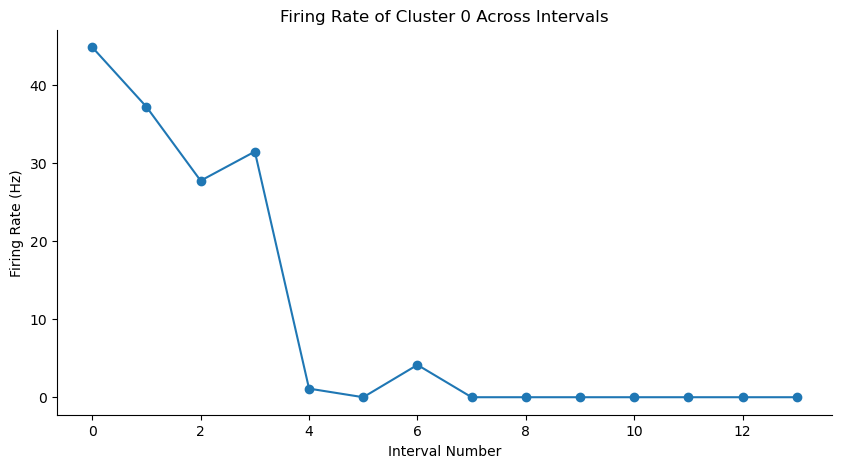

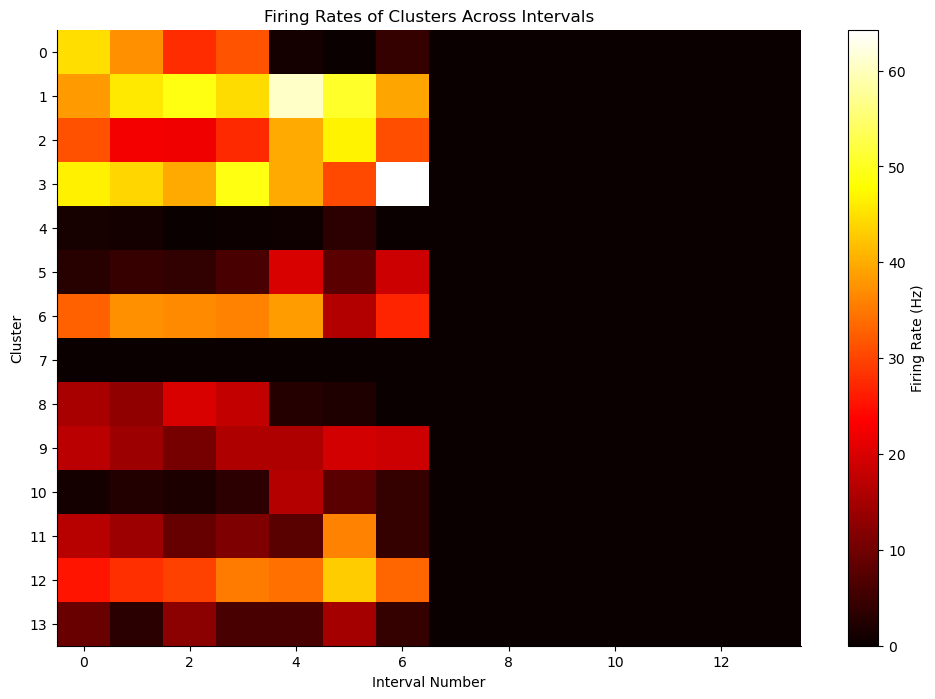

In [25]:
from collections import Counter
# Get spike times and clusters from Kilosort results
# Assuming the results are stored in spikes.kilosort_results
# Use the appropriate trial name
trial_name = VF_DRG_pre  # Ensure this matches your actual trial name in kilosort_results
kilosort_output = spikes.kilosort_results[trial_name]

st = kilosort_output['spike_times']  # Spike times in samples
clu = kilosort_output['spike_clusters']  # Cluster assignments
sampling_rate_kilosort = kilosort_output['ops']['fs']  # Sampling rate used in Kilosort (should match)

# Convert spike times to seconds
spike_times_sec = st / sampling_rate_kilosort

# Initialize a list to store firing rates per interval
firing_rates_intervals = []

# Loop over each adjusted time window
for start_time, end_time in zip(adjusted_start_times, adjusted_end_times):
    # Find spikes within the time window
    indices_in_window = np.where((spike_times_sec >= start_time) & (spike_times_sec < end_time))[0]
    spikes_in_window = st[indices_in_window]
    clusters_in_window = clu[indices_in_window]
    
    # Calculate the duration of the interval
    window_duration = end_time - start_time  # In seconds
    
    # Count the number of spikes per cluster within the window
    cluster_spike_counts = Counter(clusters_in_window)
    
    # Get all clusters present in the entire recording
    all_clusters = np.unique(clu)
    
    # Initialize firing rates with zero for all clusters
    firing_rates = {cluster: 0 for cluster in all_clusters}
    
    # Compute firing rates for clusters present in the window
    for cluster in all_clusters:
        count = cluster_spike_counts.get(cluster, 0)
        firing_rates[cluster] = count / window_duration  # Firing rate in Hz
    
    # Append the firing rates dictionary to the list
    firing_rates_intervals.append(firing_rates)

# Convert the list of dictionaries to a DataFrame
# Each row corresponds to an interval, columns are clusters
firing_rates_df = pd.DataFrame(firing_rates_intervals)

# Optionally, fill NaN values with zeros (clusters not firing in an interval)
firing_rates_df = firing_rates_df.fillna(0)

# Display the firing rates DataFrame
print("Firing Rates during Adjusted Intervals (Hz):")
print(firing_rates_df)

# Plotting the firing rates for a specific cluster across intervals
cluster_to_plot = all_clusters[0]  # Replace with the cluster you're interested in
plt.figure(figsize=(10, 5))
plt.plot(firing_rates_df[cluster_to_plot], marker='o')
plt.xlabel('Interval Number')
plt.ylabel('Firing Rate (Hz)')
plt.title(f'Firing Rate of Cluster {cluster_to_plot} Across Intervals')
plt.show()

# Optionally, plot the firing rates of all clusters as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(firing_rates_df.T, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Firing Rate (Hz)')
plt.xlabel('Interval Number')
plt.ylabel('Cluster')
plt.yticks(ticks=np.arange(len(all_clusters)), labels=all_clusters)
plt.title('Firing Rates of Clusters Across Intervals')
plt.show()

In [26]:
firing_rates_df

0          1          2          3         4          5   \
0   44.888822  38.277290  31.317783  46.628699  1.391901   2.783803   
1   37.241636  45.931351  22.344982  44.069269  1.241388   4.344858   
2   27.768136  49.090098  22.313681  39.668766  0.000000   3.966877   
3   31.503150  44.595369  27.411832  49.095819  0.409132   6.136977   
4    1.103814  60.709752  39.737292  39.737292  0.551907  19.868646   
5    0.000000  50.591629  46.828616  30.522223  3.344901   7.944140   
6    4.146223  39.389123  31.096676  64.266464  0.000000  18.658006   
7    0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
8    0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
9    0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
10   0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
11   0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
12   0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   
13   0.000000   0.000000   0.000000   0.000000  0.000000   0.000000   

           6    7          8          9          10         11         12  \
0   32.709684  0.0  15.310916  17.050793   1.043926  16.702817  25.402202   
1   37.241636  0.0  13.034573  14.275961   2.482776  14.275961  27.931227   
2   36.693608  0.0  19.834383  10.413051   1.983438   8.925472  29.751574   
3   36.003600  0.0  17.592668  15.956141   3.273055  11.046559  35.185337   
4   38.633479  0.0   2.759534  16.005298  16.557205   7.726696  34.218224   
5   16.306393  0.0   2.090563  19.233181   7.944140  35.957687  43.065602   
6   26.950453  0.0   0.000000  18.658006   4.146223   4.146223  33.169788   
7    0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
8    0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
9    0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
10   0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
11   0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
12   0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   
13   0.000000  0.0   0.000000   0.000000   0.000000   0.000000   0.000000   

           13  
0    9.047359  
1    3.103470  
2   12.396489  
3    6.136977  
4    6.070975  
5   15.052055  
6    4.146223  
7    0.000000  
8    0.000000  
9    0.000000  
10   0.000000  
11   0.000000  
12   0.000000  
13   0.000000

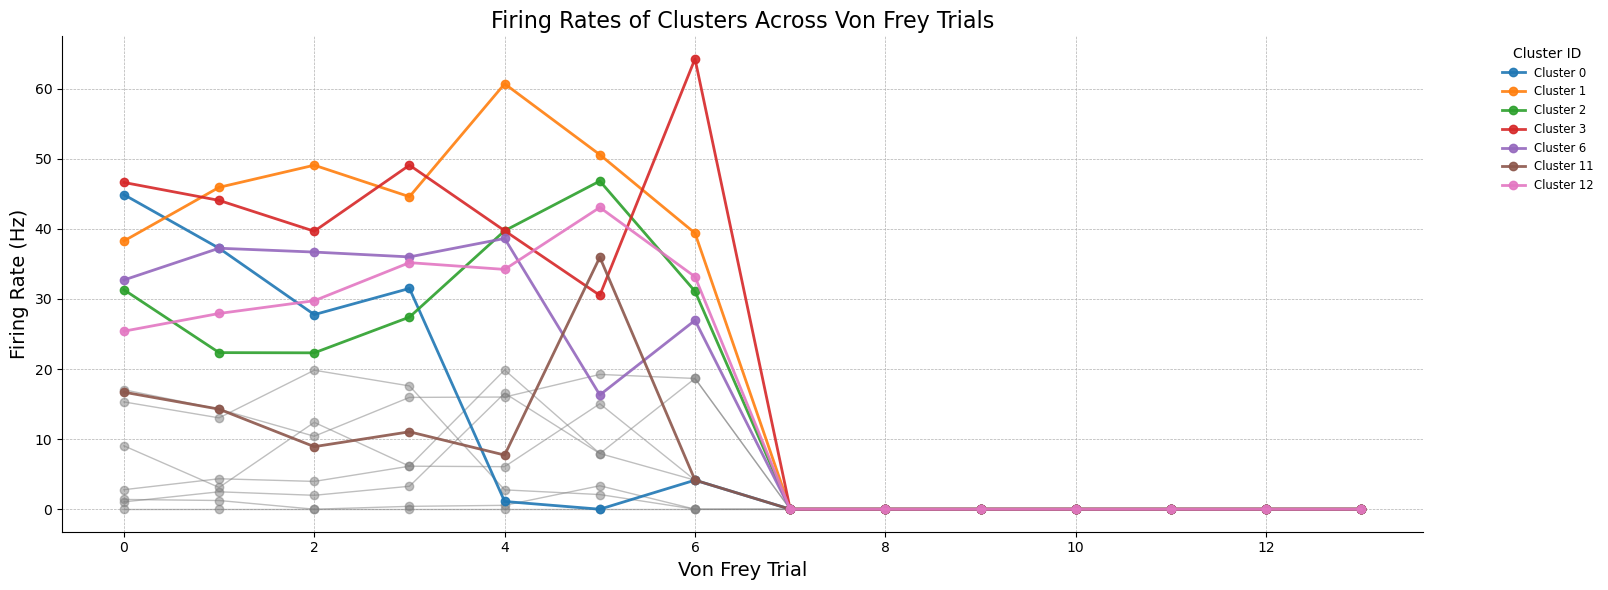

In [27]:

# Calculate the standard deviation for each cluster across intervals
std_firing_rates = firing_rates_df.std(axis=0)

# Determine a threshold for "significant change" in firing rate
# For example, clusters with a standard deviation greater than the median are highlighted
threshold = std_firing_rates.median()

# Identify units that show significant changes versus stable units
significant_units = std_firing_rates > threshold
stable_units = ~significant_units

# Plotting
plt.figure(figsize=(18, 6))

# Plot the stable units with low opacity and thinner lines
for cluster in firing_rates_df.columns[stable_units]:
    plt.plot(firing_rates_df[cluster], marker='o', linestyle='-', linewidth=1, alpha=0.5, color='gray')

# Plot the significant units with higher opacity and thicker lines
for cluster in firing_rates_df.columns[significant_units]:
    plt.plot(firing_rates_df[cluster], marker='o', linestyle='-', linewidth=2, alpha=0.9, label=f'Cluster {cluster}')

# Highlighting
plt.xlabel('Von Frey Trial', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Firing Rates of Clusters Across Von Frey Trials', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Add a legend for clusters with significant changes outside the plot
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)

# Adjust layout to accommodate the legend outside the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the plot area to make space for the legend
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\firing_rates.png', dpi=300, bbox_inches='tight')
plt.show()


## extracting spikes in useful range of 2Hz to 15Hz

(1) Hao, H.; Ramli, R.; Wang, C.; Liu, C.; Shah, S.; Mullen, P.; Lall, V.; Jones, F.; Shao, J.; Zhang, H.; Jaffe, D. B.; Gamper, N.; Du, X. Dorsal Root Ganglia Control Nociceptive Input to the Central Nervous System. PLoS Biol 2023, 21 (1), e3001958. https://doi.org/10.1371/journal.pbio.3001958.


Filtered Firing Rates during Adjusted Intervals (Hz):
           0          5          8          9          10         11  \
0   44.888822   2.783803  15.310916  17.050793   1.043926  16.702817   
1   37.241636   4.344858  13.034573  14.275961   2.482776  14.275961   
2   27.768136   3.966877  19.834383  10.413051   1.983438   8.925472   
3   31.503150   6.136977  17.592668  15.956141   3.273055  11.046559   
4    1.103814  19.868646   2.759534  16.005298  16.557205   7.726696   
5    0.000000   7.944140   2.090563  19.233181   7.944140  35.957687   
6    4.146223  18.658006   0.000000  18.658006   4.146223   4.146223   
7    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
8    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
9    0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
10   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
11   0.000000   0.000000   0.000000   0.000000   0.000000   0.000000   
12   0.000

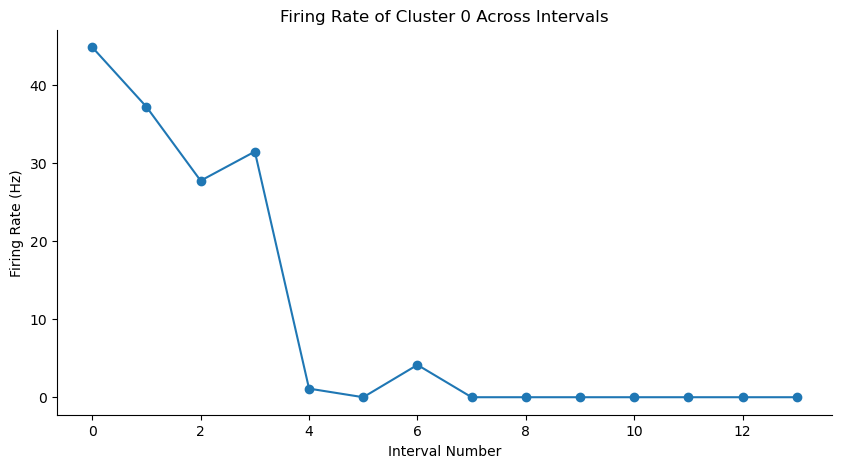

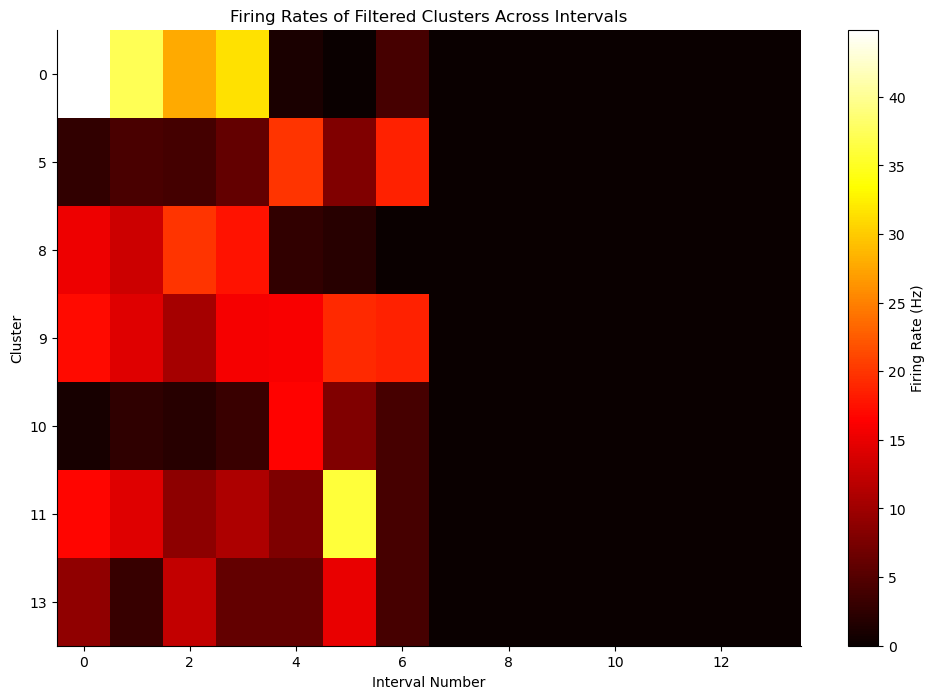

In [28]:
from collections import Counter
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Assuming `spikes` is a Kilosort_wrapper instance and `VF_DRG_pre` is the trial name
trial_name = VF_DRG_pre
kilosort_output = spikes.kilosort_results[trial_name]

st = kilosort_output['spike_times']  # Spike times in samples
clu = kilosort_output['spike_clusters']  # Cluster assignments
sampling_rate_kilosort = kilosort_output['ops']['fs']  # Sampling rate used in Kilosort (should match)

# Convert spike times to seconds
spike_times_sec = st / sampling_rate_kilosort

# Initialize a list to store firing rates per interval
firing_rates_intervals = []

# Loop over each adjusted time window
for start_time, end_time in zip(adjusted_start_times, adjusted_end_times):
    # Find spikes within the time window
    indices_in_window = np.where((spike_times_sec >= start_time) & (spike_times_sec < end_time))[0]
    spikes_in_window = st[indices_in_window]
    clusters_in_window = clu[indices_in_window]
    
    # Calculate the duration of the interval
    window_duration = end_time - start_time  # In seconds
    
    # Count the number of spikes per cluster within the window
    cluster_spike_counts = Counter(clusters_in_window)
    
    # Get all clusters present in the entire recording
    all_clusters = np.unique(clu)
    
    # Initialize firing rates with zero for all clusters
    firing_rates = {cluster: 0 for cluster in all_clusters}
    
    # Compute firing rates for clusters present in the window
    for cluster in all_clusters:
        count = cluster_spike_counts.get(cluster, 0)
        firing_rates[cluster] = count / window_duration  # Firing rate in Hz
    
    # Append the firing rates dictionary to the list
    firing_rates_intervals.append(firing_rates)

# Convert the list of dictionaries to a DataFrame
# Each row corresponds to an interval, columns are clusters
firing_rates_df = pd.DataFrame(firing_rates_intervals)

# Optionally, fill NaN values with zeros (clusters not firing in an interval)
firing_rates_df = firing_rates_df.fillna(0)

# Calculate the average firing rate for each cluster across all intervals
average_firing_rates = firing_rates_df.mean()

# Filter clusters with average firing rates between 2.5Hz and 15Hz
filtered_clusters = average_firing_rates[(average_firing_rates >= 2) & (average_firing_rates <= 15)].index

# Filter the firing rates DataFrame to only include the desired clusters
firing_rates_df_filtered = firing_rates_df[filtered_clusters]

# Display the filtered firing rates DataFrame
print("Filtered Firing Rates during Adjusted Intervals (Hz):")
print(firing_rates_df_filtered)

# Plotting the firing rates for a specific filtered cluster across intervals
if not filtered_clusters.empty:
    cluster_to_plot = filtered_clusters[0]  # Replace with the cluster you're interested in
    plt.figure(figsize=(10, 5))
    plt.plot(firing_rates_df_filtered[cluster_to_plot], marker='o')
    plt.xlabel('Interval Number')
    plt.ylabel('Firing Rate (Hz)')
    plt.title(f'Firing Rate of Cluster {cluster_to_plot} Across Intervals')
    plt.show()

# Optionally, plot the firing rates of all filtered clusters as a heatmap
plt.figure(figsize=(12, 8))
plt.imshow(firing_rates_df_filtered.T, aspect='auto', cmap='hot', interpolation='nearest')
plt.colorbar(label='Firing Rate (Hz)')
plt.xlabel('Interval Number')
plt.ylabel('Cluster')
plt.yticks(ticks=np.arange(len(filtered_clusters)), labels=filtered_clusters)
plt.title('Firing Rates of Filtered Clusters Across Intervals')
plt.show()


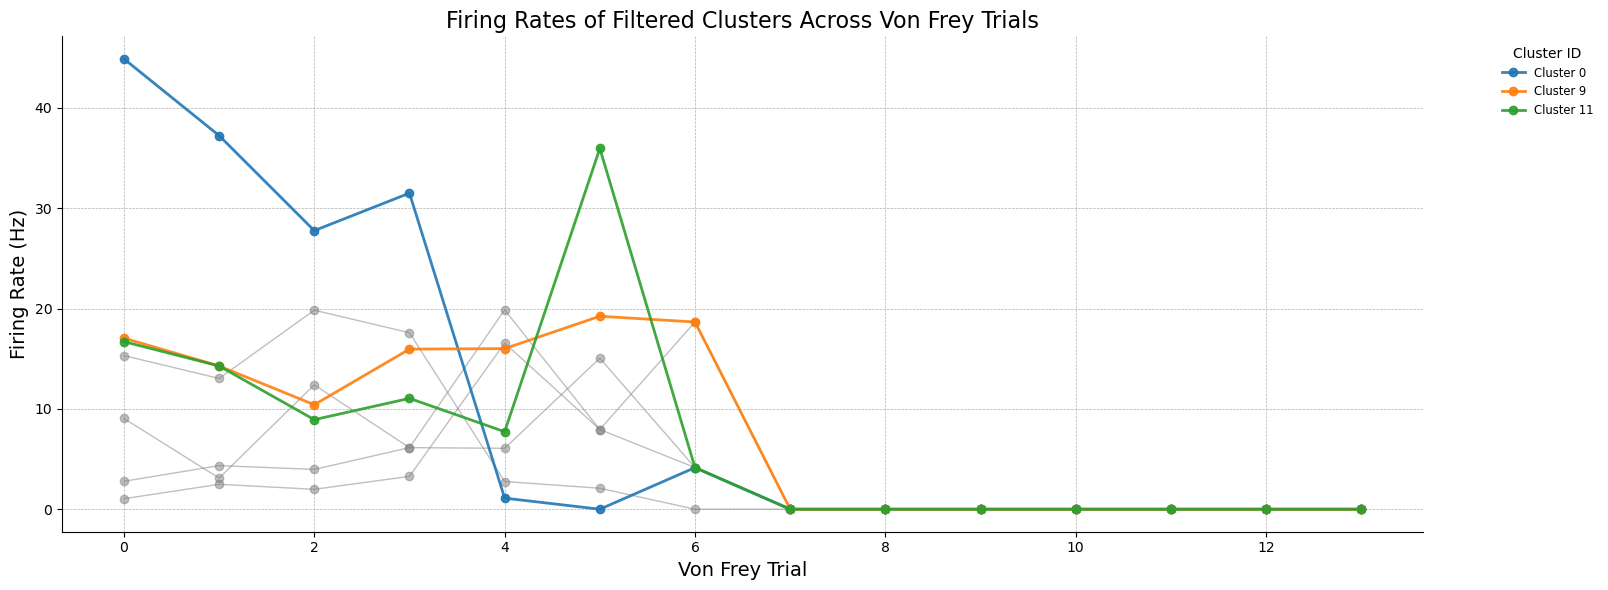

In [29]:
# Calculate the standard deviation for each cluster across intervals (only for filtered clusters)
std_firing_rates_filtered = firing_rates_df_filtered.std(axis=0)

# Determine a threshold for "significant change" in firing rate (using median of filtered clusters)
threshold_filtered = std_firing_rates_filtered.median()

# Identify units that show significant changes versus stable units among filtered clusters
significant_units_filtered = std_firing_rates_filtered > threshold_filtered
stable_units_filtered = ~significant_units_filtered

# Plotting only the filtered clusters
plt.figure(figsize=(18, 6))

# Plot the stable units with low opacity and thinner lines (filtered clusters only)
for cluster in firing_rates_df_filtered.columns[stable_units_filtered]:
    plt.plot(firing_rates_df_filtered[cluster], marker='o', linestyle='-', linewidth=1, alpha=0.5, color='gray')

# Plot the significant units with higher opacity and thicker lines (filtered clusters only)
for cluster in firing_rates_df_filtered.columns[significant_units_filtered]:
    plt.plot(firing_rates_df_filtered[cluster], marker='o', linestyle='-', linewidth=2, alpha=0.9, label=f'Cluster {cluster}')

# Highlighting
plt.xlabel('Von Frey Trial', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Firing Rates of Filtered Clusters Across Von Frey Trials', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Optional: Add a legend for clusters with significant changes outside the plot
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)

# Adjust layout to accommodate the legend outside the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the plot area to make space for the legend
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\firing_rates_filtered.png', dpi=300, bbox_inches='tight')
plt.show()


             Trial Set  Von Frey Voltage (uV)  Average Firing Rate (Hz)
0    First Half Trials           522060.53125                 15.261205
1    First Half Trials           570568.00000                 12.679890
2    First Half Trials           556760.25000                 12.183978
3    First Half Trials           655580.56250                 13.092218
4    First Half Trials           545050.43750                 10.013167
5    First Half Trials           777930.56250                 12.603110
6    First Half Trials           241632.71875                  7.700129
7   Second Half Trials           542330.25000                  0.000000
8   Second Half Trials           525990.87500                  0.000000
9   Second Half Trials           549662.00000                  0.000000
10  Second Half Trials           564767.37500                  0.000000
11  Second Half Trials           618206.56250                  0.000000
12  Second Half Trials           643666.56250                  0

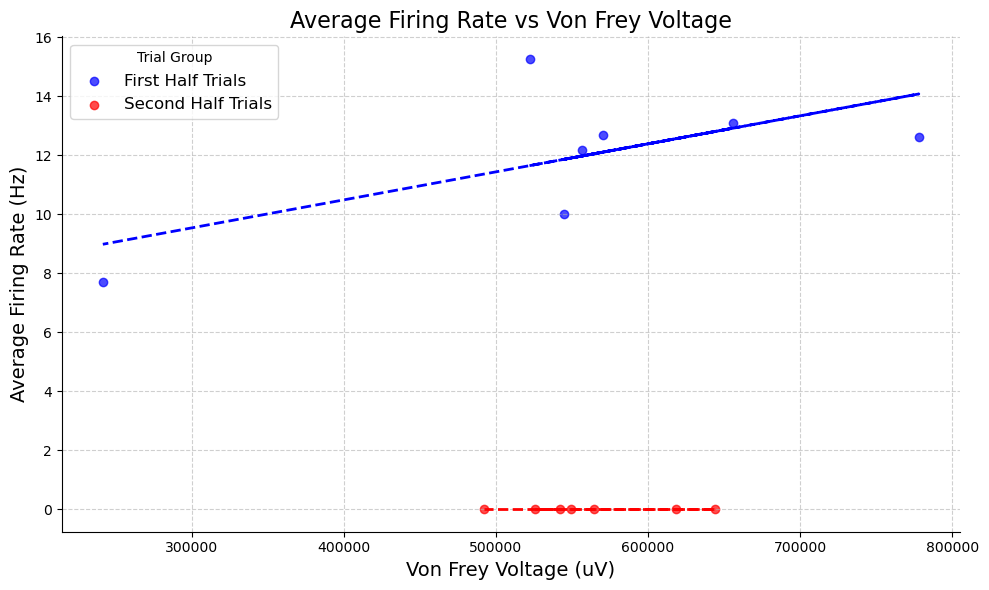

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices].mean(axis=1)
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices].mean(axis=1)

# Create a pandas DataFrame with the results
data = {
    "Trial Set": ["First Half Trials"] * len(first_half_indices) + ["Second Half Trials"] * len(second_half_indices),
    "Von Frey Voltage (uV)": list(von_frey_first_half) + list(von_frey_second_half),
    "Average Firing Rate (Hz)": list(firing_rates_first_half) + list(firing_rates_second_half)
}

df_comparison = pd.DataFrame(data)

# Display the DataFrame
print(df_comparison)

# Scatter plot the relationship between Von Frey voltage and spiking rate for each group
plt.figure(figsize=(10, 6))

# Scatter plot for the first half trials
plt.scatter(von_frey_first_half, firing_rates_first_half, color='blue', alpha=0.7, label='First Half Trials')

# Scatter plot for the second half trials
plt.scatter(von_frey_second_half, firing_rates_second_half, color='red', alpha=0.7, label='Second Half Trials')

# Calculate and plot trend lines
# First half trend line
slope, intercept, r_value, p_value, std_err = linregress(von_frey_first_half, firing_rates_first_half)
trendline_first_half = intercept + slope * np.array(von_frey_first_half)
plt.plot(von_frey_first_half, trendline_first_half, color='blue', linestyle='--', linewidth=2)

# Second half trend line
slope, intercept, r_value, p_value, std_err = linregress(von_frey_second_half, firing_rates_second_half)
trendline_second_half = intercept + slope * np.array(von_frey_second_half)
plt.plot(von_frey_second_half, trendline_second_half, color='red', linestyle='--', linewidth=2)

# Labels and legend
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Average Firing Rate (Hz)', fontsize=14)
plt.title('Average Firing Rate vs Von Frey Voltage', fontsize=16)
plt.legend(title='Trial Group', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot if needed
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\von_frey_vs_firing_rate_trendline.png', dpi=300, bbox_inches='tight')
plt.show()


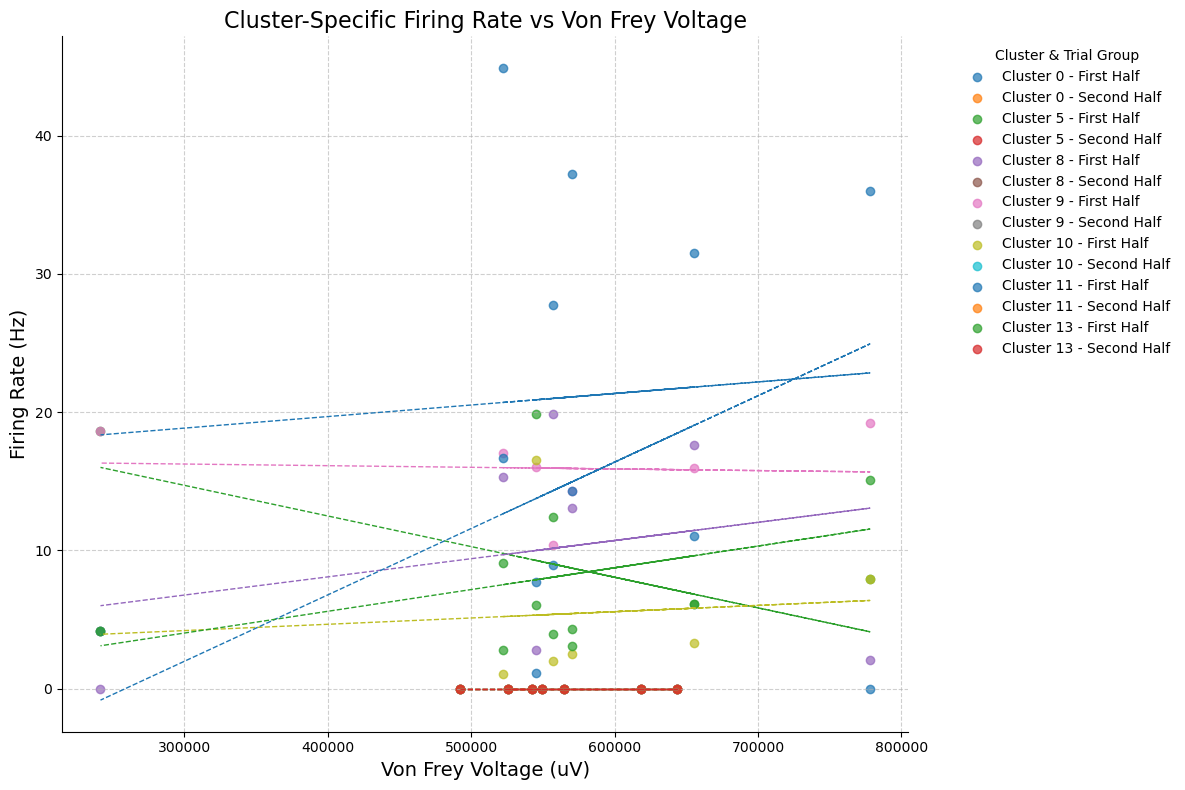

In [31]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Filter firing rates for first and second half for each cluster
firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices]

# Plot the firing rate for each cluster in first and second half of the trials
plt.figure(figsize=(12, 8))

# Iterate through each cluster
for cluster in firing_rates_df_filtered.columns:
    # Extract firing rate data for the cluster
    firing_rate_first_half = firing_rates_first_half[cluster]
    firing_rate_second_half = firing_rates_second_half[cluster]
    
    # Scatter plot for first and second half
    plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, label=f'Cluster {cluster} - First Half')
    plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, label=f'Cluster {cluster} - Second Half')
    
    # Trend lines for each cluster
    if len(von_frey_first_half) > 1:
        # Linear regression for the first half
        slope, intercept, _, _, _ = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)
        plt.plot(von_frey_first_half, trendline_first_half, linestyle='--', linewidth=1)

    if len(von_frey_second_half) > 1:
        # Linear regression for the second half
        slope, intercept, _, _, _ = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)
        plt.plot(von_frey_second_half, trendline_second_half, linestyle='--', linewidth=1)

# Labels and legend
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend configuration to avoid overlap
plt.legend(title='Cluster & Trial Group', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()

# Save the plot if needed
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\von_frey_vs_firing_rate_individual_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


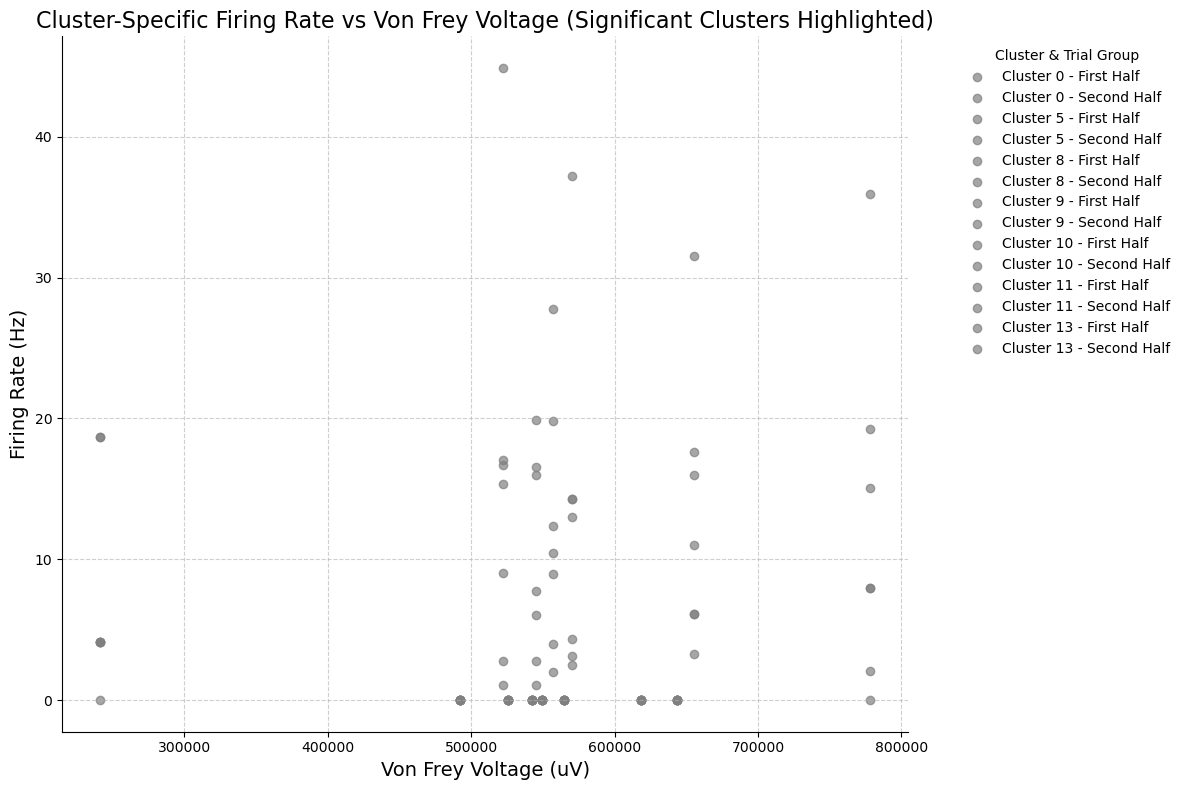

In [32]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Filter firing rates for first and second half for each cluster
firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices]

# Set a significance level (p-value threshold)
significance_level = 0.05

# Initialize a figure for plotting
plt.figure(figsize=(12, 8))

# Iterate through each cluster to perform linear regression and determine significance
for cluster in firing_rates_df_filtered.columns:
    # Extract firing rate data for the cluster
    firing_rate_first_half = firing_rates_first_half[cluster]
    firing_rate_second_half = firing_rates_second_half[cluster]
    
    # Perform linear regression for the first half
    if len(von_frey_first_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)
        
        # Scatter plot for first half
        plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, label=f'Cluster {cluster} - First Half', color='blue' if p_value < significance_level else 'gray')
        
        # Plot trend line only if significant
        if p_value < significance_level:
            plt.plot(von_frey_first_half, trendline_first_half, linestyle='--', linewidth=1.5, color='blue')

    # Perform linear regression for the second half
    if len(von_frey_second_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)
        
        # Scatter plot for second half
        plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, label=f'Cluster {cluster} - Second Half', color='red' if p_value < significance_level else 'gray')
        
        # Plot trend line only if significant
        if p_value < significance_level:
            plt.plot(von_frey_second_half, trendline_second_half, linestyle='--', linewidth=1.5, color='red')

# Labels and legend
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Cluster-Specific Firing Rate vs Von Frey Voltage (Significant Clusters Highlighted)', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)

# Legend configuration to avoid overlap
plt.legend(title='Cluster & Trial Group', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)

plt.tight_layout()

# Save the plot if needed
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\von_frey_vs_firing_rate_significant_clusters.png', dpi=300, bbox_inches='tight')
plt.show()


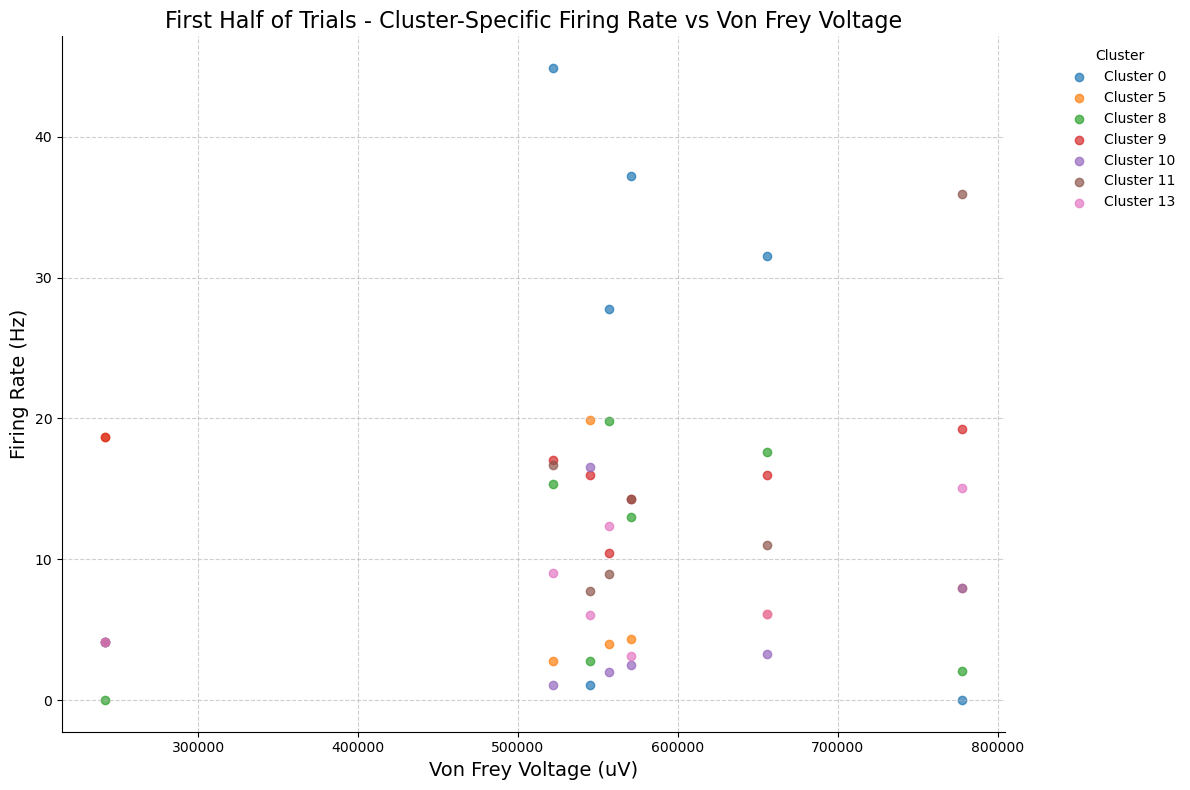

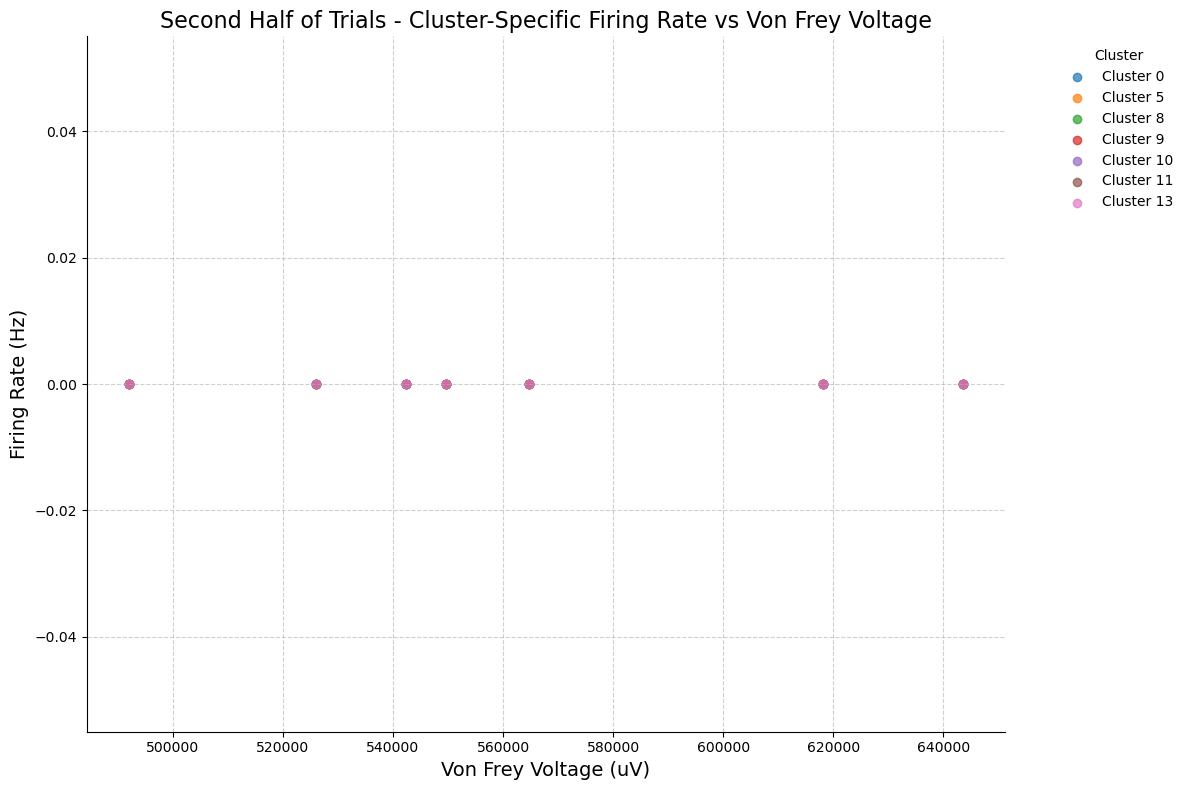

In [33]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Filter firing rates for first and second half for each cluster
firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices]

# Set a significance level (p-value threshold)
significance_level = 0.05

### First Half Plot ###
plt.figure(figsize=(12, 8))
for cluster in firing_rates_df_filtered.columns:
    # Extract firing rate data for the cluster in the first half
    firing_rate_first_half = firing_rates_first_half[cluster]

    # Scatter plot for the first half
    plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, label=f'Cluster {cluster}')

    # Perform linear regression for the first half
    if len(von_frey_first_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)
        
        # Plot trend line only if significant
        if p_value < significance_level:
            plt.plot(von_frey_first_half, trendline_first_half, linestyle='--', linewidth=2, label=f'Cluster {cluster} Trend (Significant)')

# Labels and legend for the first half
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('First Half of Trials - Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save the first half plot
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\first_half_von_frey_vs_firing_rate.png', dpi=300, bbox_inches='tight')
plt.show()


### Second Half Plot ###
plt.figure(figsize=(12, 8))
for cluster in firing_rates_df_filtered.columns:
    # Extract firing rate data for the cluster in the second half
    firing_rate_second_half = firing_rates_second_half[cluster]

    # Scatter plot for the second half
    plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, label=f'Cluster {cluster}')

    # Perform linear regression for the second half
    if len(von_frey_second_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)

        # Plot trend line only if significant
        if p_value < significance_level:
            plt.plot(von_frey_second_half, trendline_second_half, linestyle='--', linewidth=2, label=f'Cluster {cluster} Trend (Significant)')

# Labels and legend for the second half
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Second Half of Trials - Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save the second half plot
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\second_half_von_frey_vs_firing_rate.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\KarlJ\AppData\Local\Temp\ipykernel_30756\3316907038.py:32: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.



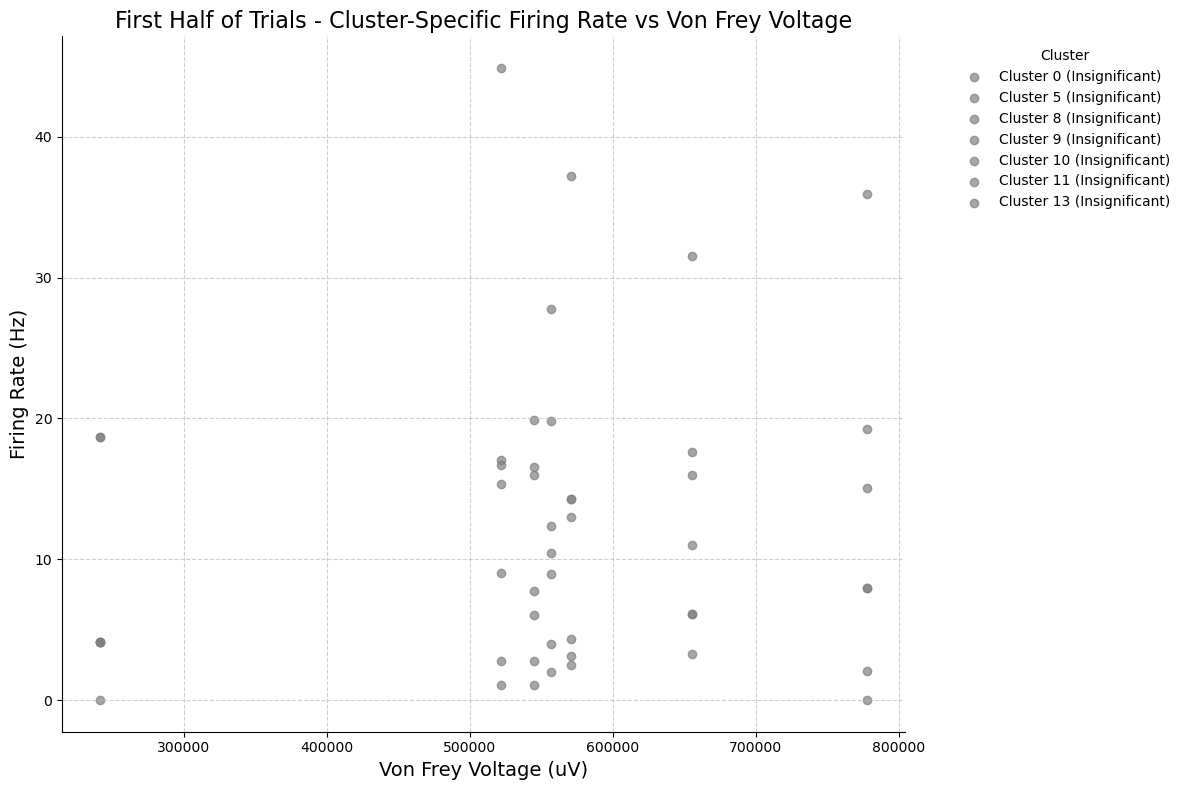

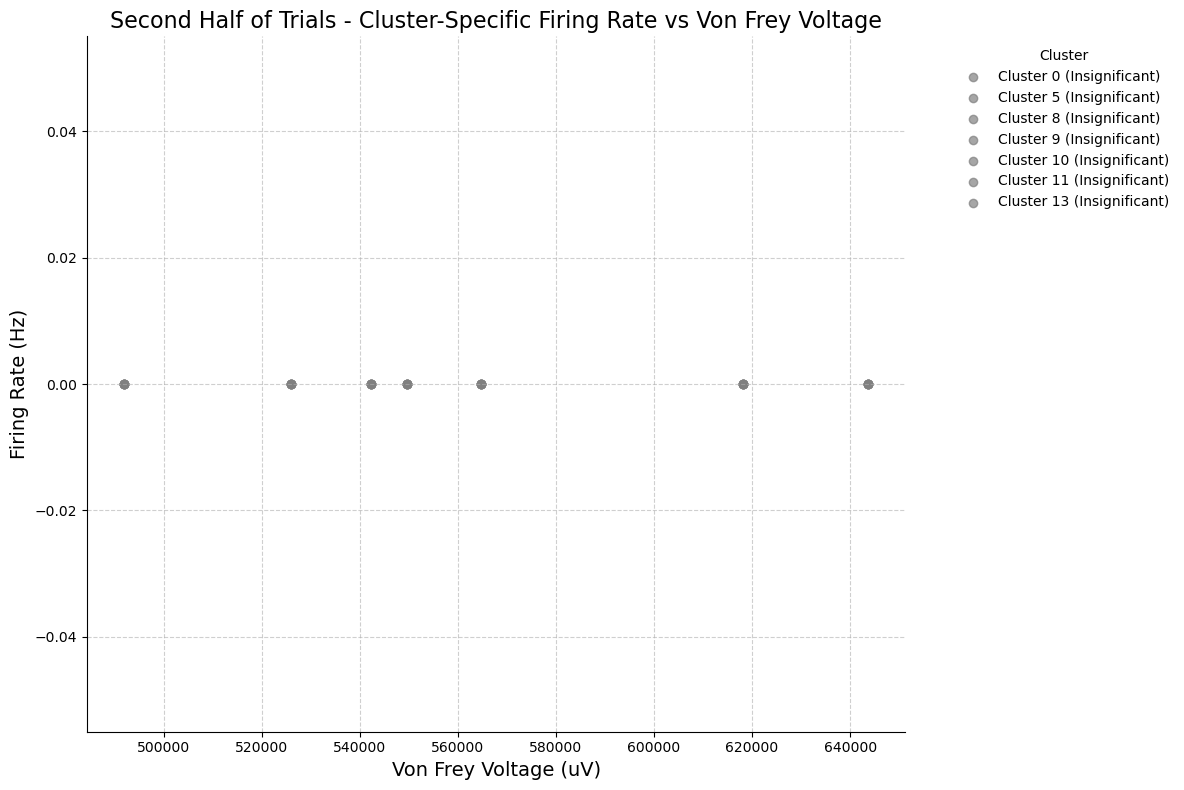

In [34]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress
import matplotlib.cm as cm

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and last half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Filter firing rates for first and second half for each cluster
firing_rates_first_half = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half = firing_rates_df_filtered.iloc[second_half_indices]

# Set a significance level (p-value threshold)
significance_level = 0.05

# Set up color map to give each cluster a unique color
num_clusters = len(firing_rates_df_filtered.columns)
color_map = cm.get_cmap('tab20', num_clusters)  # Use 'tab20' for up to 20 distinct colors

### First Half Plot ###
plt.figure(figsize=(12, 8))
for idx, cluster in enumerate(firing_rates_df_filtered.columns):
    # Extract firing rate data for the cluster in the first half
    firing_rate_first_half = firing_rates_first_half[cluster]

    # Perform linear regression for the first half
    if len(von_frey_first_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)

        # Plot cluster in gray if not significant, otherwise color it
        if p_value < significance_level:
            # Scatter plot for significant clusters
            plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, label=f'Cluster {cluster}', color=color_map(idx))
            # Plot significant trend line
            plt.plot(von_frey_first_half, trendline_first_half, linestyle='--', linewidth=2, color=color_map(idx), label=f'Cluster {cluster} Trend (Significant)')
        else:
            # Scatter plot for insignificant clusters
            plt.scatter(von_frey_first_half, firing_rate_first_half, alpha=0.7, color='gray', label=f'Cluster {cluster} (Insignificant)')

# Labels and legend for the first half
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('First Half of Trials - Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save the first half plot
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\first_half_von_frey_vs_firing_rate_colored.png', dpi=300, bbox_inches='tight')
plt.show()


### Second Half Plot ###
plt.figure(figsize=(12, 8))
for idx, cluster in enumerate(firing_rates_df_filtered.columns):
    # Extract firing rate data for the cluster in the second half
    firing_rate_second_half = firing_rates_second_half[cluster]

    # Perform linear regression for the second half
    if len(von_frey_second_half) > 1:
        slope, intercept, r_value, p_value, std_err = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)

        # Plot cluster in gray if not significant, otherwise color it
        if p_value < significance_level:
            # Scatter plot for significant clusters
            plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, label=f'Cluster {cluster}', color=color_map(idx))
            # Plot significant trend line
            plt.plot(von_frey_second_half, trendline_second_half, linestyle='--', linewidth=2, color=color_map(idx), label=f'Cluster {cluster} Trend (Significant)')
        else:
            # Scatter plot for insignificant clusters
            plt.scatter(von_frey_second_half, firing_rate_second_half, alpha=0.7, color='gray', label=f'Cluster {cluster} (Insignificant)')

# Labels and legend for the second half
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Second Half of Trials - Cluster-Specific Firing Rate vs Von Frey Voltage', fontsize=16)
plt.grid(True, linestyle='--', alpha=0.6)
plt.legend(title='Cluster', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.tight_layout()

# Save the second half plot
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\second_half_von_frey_vs_firing_rate_colored.png', dpi=300, bbox_inches='tight')
plt.show()


# Raster Plots: plot good units, then plot all units

Number of good units: 1
Filtered Firing Rates DataFrame:
            0
0   44.888822
1   37.241636
2   27.768136
3   31.503150
4    1.103814
5    0.000000
6    4.146223
7    0.000000
8    0.000000
9    0.000000
10   0.000000
11   0.000000
12   0.000000
13   0.000000


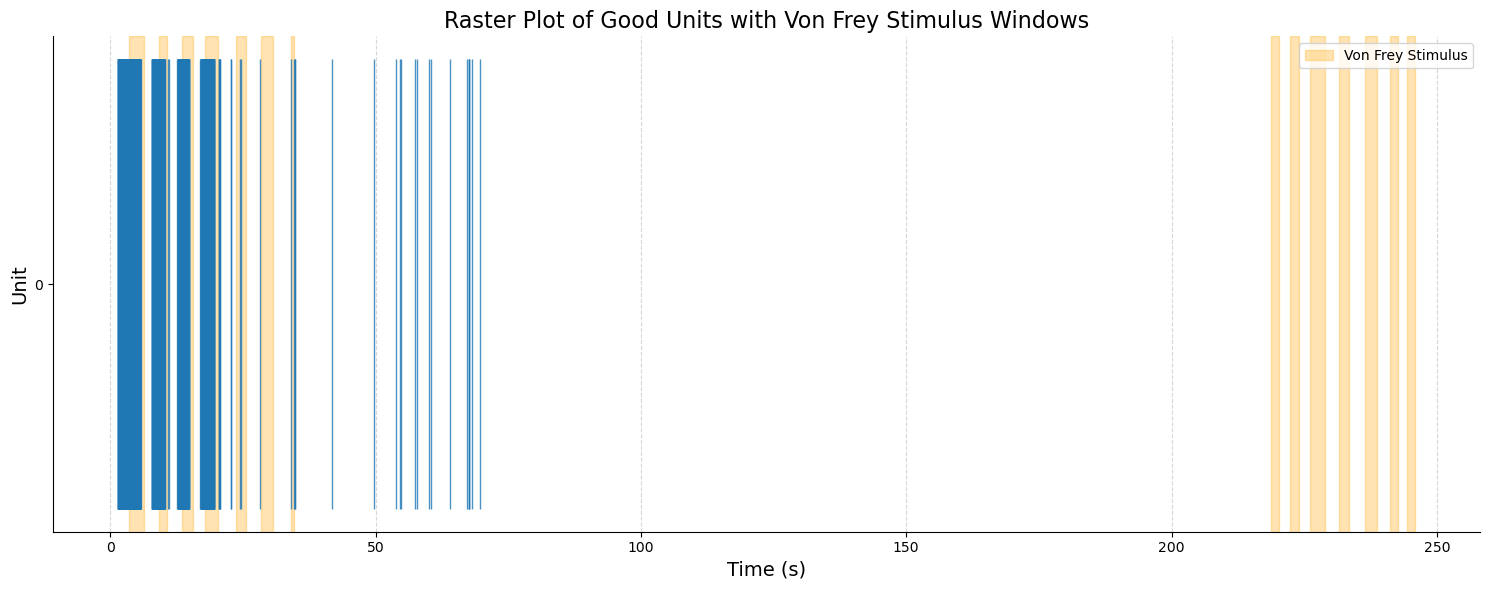

In [35]:


# Assuming you have kilosort results loaded into 'kilosort_output'

# Extract cluster amplitudes, contamination levels, and firing rates
cluster_amplitudes = kilosort_output.get('cluster_amplitudes', None)
contamination_percentages = kilosort_output.get('contamination_percentage', None)
average_firing_rates = firing_rates_df.mean(axis=0)

# Set thresholds for filtering
amplitude_threshold = 20  # uV, adjust as per your requirement
contamination_threshold = 50  # %, adjust as needed
firing_rate_threshold = 0.5  # Hz, filter units with firing rates below 0.5 Hz

# Apply filtering based on available quality metrics
good_units_mask = np.ones(len(average_firing_rates), dtype=bool)

# Filter based on amplitudes
if cluster_amplitudes is not None:
    good_units_mask &= cluster_amplitudes > amplitude_threshold

# Filter based on contamination percentage
if contamination_percentages is not None:
    good_units_mask &= contamination_percentages < contamination_threshold

# Filter based on average firing rate
good_units_mask &= average_firing_rates > firing_rate_threshold

# Apply mask to filter out bad units
good_units = average_firing_rates.index[good_units_mask]

# Update the firing_rates_df to only include good units
firing_rates_df_filtered = firing_rates_df[good_units]

# Now 'firing_rates_df_filtered' only contains data from units that passed the filtering criteria
print(f"Number of good units: {len(good_units)}")
print("Filtered Firing Rates DataFrame:")
print(firing_rates_df_filtered)



# Assume `spike_times_sec` contains all spike times in seconds
# `clu` contains corresponding cluster assignments for each spike time
# `good_units` contains the indices of the units that passed the filtering

# Filtering spike times for good units
good_spike_indices = np.isin(clu, good_units)
good_spike_times = spike_times_sec[good_spike_indices]
good_clusters = clu[good_spike_indices]

# Sort the good units to make plotting easier
sorted_good_units = sorted(good_units)

# Create a figure for the raster plot
plt.figure(figsize=(15, 6))

# Loop through each unit and plot its spikes
for unit_idx, unit in enumerate(sorted_good_units):
    unit_spike_times = good_spike_times[good_clusters == unit]
    
    # Plot each spike as a vertical line at the appropriate time
    plt.vlines(unit_spike_times, unit_idx + 0.5, unit_idx + 1.5, color=f'C{unit_idx % 10}', alpha=0.8, linewidth=1)

# Label the axes and add titles similar to the figure
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Unit', fontsize=14)
plt.yticks(np.arange(1, len(sorted_good_units) + 1), labels=[str(unit) for unit in sorted_good_units])
plt.title('Raster Plot of Good Units with Von Frey Stimulus Windows', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add sections to show Von Frey stimulus windows
for start, end in zip(adjusted_start_times, adjusted_end_times):
    plt.axvspan(start, end, color='orange', alpha=0.3, label='Von Frey Stimulus')

# Avoid duplicate labels in the legend
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()


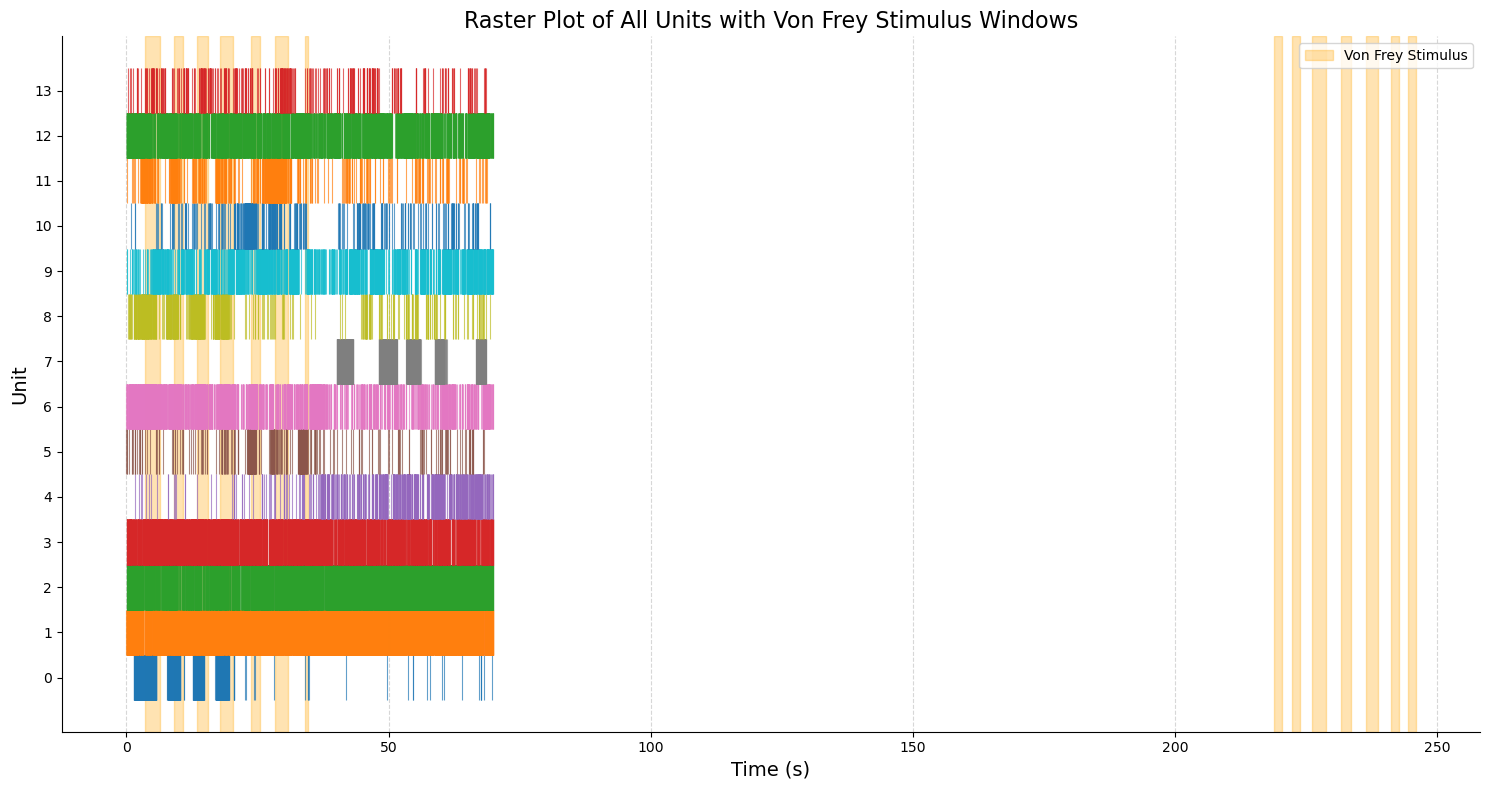

In [36]:
import numpy as np
import matplotlib.pyplot as plt

# Assume `spike_times_sec` contains all spike times in seconds
# `clu` contains corresponding cluster assignments for each spike time

# Get all unique units from the cluster assignments
all_units = np.unique(clu)

# Create a figure for the raster plot
plt.figure(figsize=(15, 8))

# Loop through each unit and plot its spikes
for unit_idx, unit in enumerate(all_units):
    unit_spike_times = spike_times_sec[clu == unit]
    
    # Plot each spike as a vertical line at the appropriate time
    plt.vlines(unit_spike_times, unit_idx + 0.5, unit_idx + 1.5, color=f'C{unit_idx % 10}', alpha=0.7, linewidth=0.8)

# Label the axes and add title
plt.xlabel('Time (s)', fontsize=14)
plt.ylabel('Unit', fontsize=14)
plt.yticks(np.arange(1, len(all_units) + 1), labels=[str(unit) for unit in all_units])
plt.title('Raster Plot of All Units with Von Frey Stimulus Windows', fontsize=16)
plt.grid(axis='x', linestyle='--', alpha=0.5)

# Add sections to show Von Frey stimulus windows
for start, end in zip(adjusted_start_times, adjusted_end_times):
    plt.axvspan(start, end, color='orange', alpha=0.3, label='Von Frey Stimulus')

# Avoid duplicate labels in the legend for stimulus windows
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), loc='upper right')

plt.tight_layout()
plt.show()


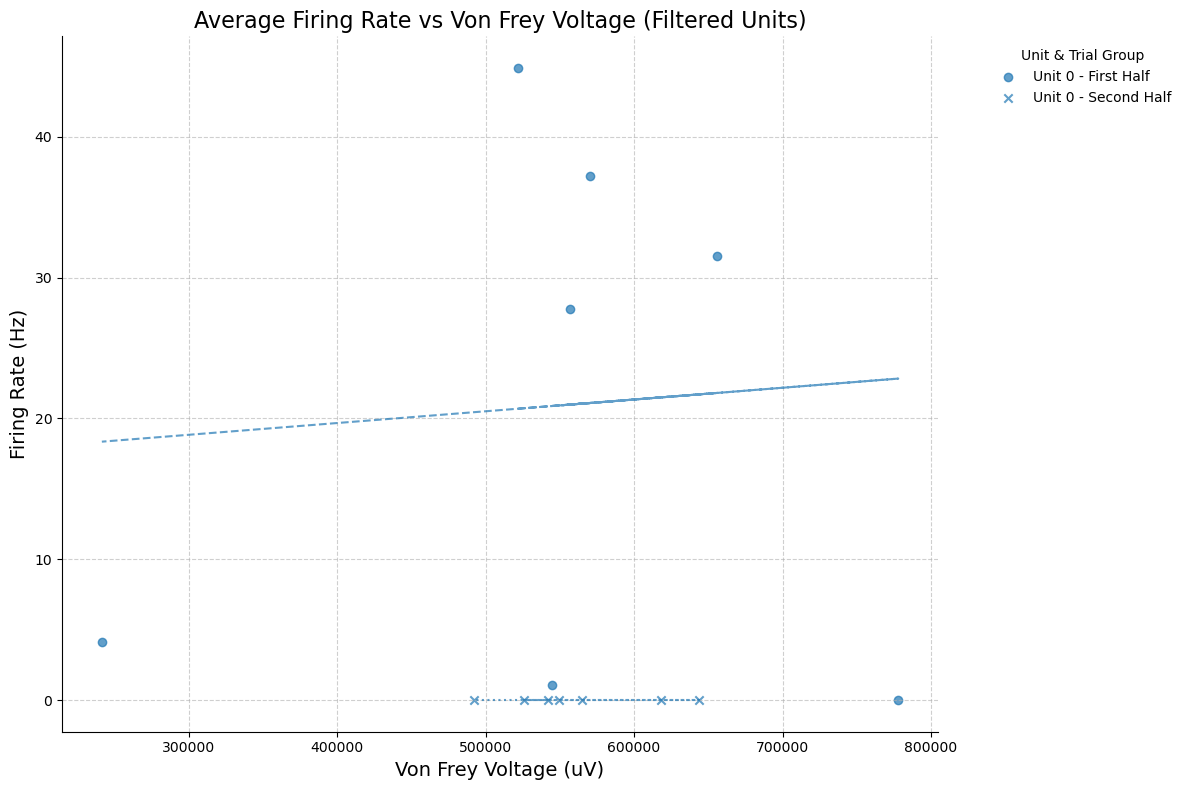

In [37]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and second half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Extract firing rates for filtered units (i.e., good units only) for each half
firing_rates_first_half_filtered = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half_filtered = firing_rates_df_filtered.iloc[second_half_indices]

# Prepare figure for the plot
plt.figure(figsize=(12, 8))

# Loop through each filtered unit and plot its data separately for first and second half
for unit_idx, unit in enumerate(firing_rates_df_filtered.columns):
    firing_rate_first_half = firing_rates_first_half_filtered[unit]
    firing_rate_second_half = firing_rates_second_half_filtered[unit]
    
    # Scatter plot for the first half trials
    plt.scatter(von_frey_first_half, firing_rate_first_half, color=f'C{unit_idx % 10}', alpha=0.7, label=f'Unit {unit} - First Half')
    
    # Scatter plot for the second half trials
    plt.scatter(von_frey_second_half, firing_rate_second_half, color=f'C{unit_idx % 10}', alpha=0.7, marker='x', label=f'Unit {unit} - Second Half')
    
    # Calculate and plot trend lines
    # First half trend line
    if len(von_frey_first_half) > 1:
        slope, intercept, _, _, _ = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)
        plt.plot(von_frey_first_half, trendline_first_half, color=f'C{unit_idx % 10}', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Second half trend line
    if len(von_frey_second_half) > 1:
        slope, intercept, _, _, _ = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)
        plt.plot(von_frey_second_half, trendline_second_half, color=f'C{unit_idx % 10}', linestyle=':', linewidth=1.5, alpha=0.7)

# Labels and legend
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Average Firing Rate vs Von Frey Voltage (Filtered Units)', fontsize=16)
plt.legend(title='Unit & Trial Group', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot if needed
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\filtered_units_von_frey_vs_firing_rate_trendline.png', dpi=300, bbox_inches='tight')
plt.show()


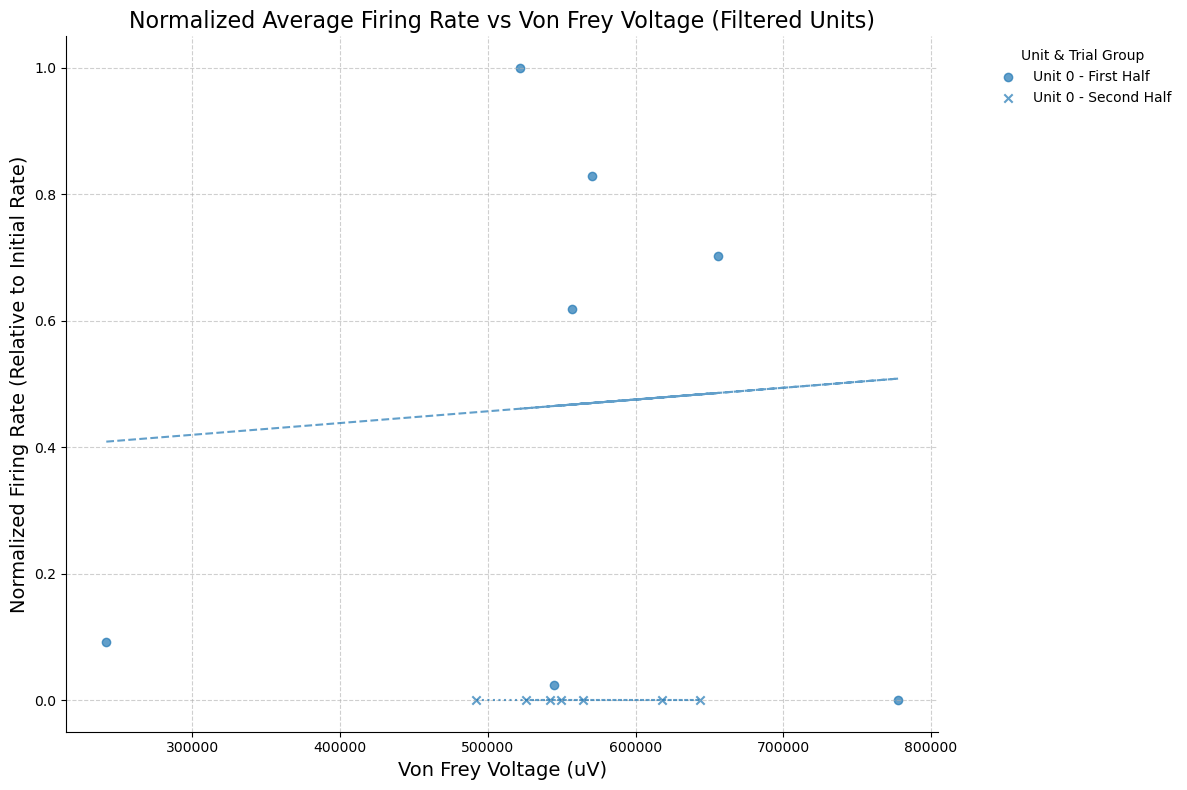

In [38]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import linregress

# Assume von_frey_averages and firing_rates_df_filtered have been computed earlier

# Get the total number of trials available
total_trials = len(von_frey_averages)

# Calculate midpoint to split the trials into two halves
mid_point = total_trials // 2

# Split data into first half and second half of trials
first_half_indices = list(range(mid_point))
second_half_indices = list(range(mid_point, total_trials))

# Extract data for the first and second half of trials
von_frey_first_half = von_frey_averages[first_half_indices]
von_frey_second_half = von_frey_averages[second_half_indices]

# Extract firing rates for filtered units (i.e., good units only) for each half
firing_rates_first_half_filtered = firing_rates_df_filtered.iloc[first_half_indices]
firing_rates_second_half_filtered = firing_rates_df_filtered.iloc[second_half_indices]

# Normalize each unit's firing rate by its initial value (first trial)
normalized_firing_rates_first_half = firing_rates_first_half_filtered.div(firing_rates_first_half_filtered.iloc[0])
normalized_firing_rates_second_half = firing_rates_second_half_filtered.div(firing_rates_first_half_filtered.iloc[0])

# Prepare figure for the plot
plt.figure(figsize=(12, 8))

# Loop through each filtered unit and plot its data separately for first and second half
for unit_idx, unit in enumerate(firing_rates_df_filtered.columns):
    firing_rate_first_half = normalized_firing_rates_first_half[unit]
    firing_rate_second_half = normalized_firing_rates_second_half[unit]
    
    # Scatter plot for the first half trials
    plt.scatter(von_frey_first_half, firing_rate_first_half, color=f'C{unit_idx % 10}', alpha=0.7, label=f'Unit {unit} - First Half')
    
    # Scatter plot for the second half trials
    plt.scatter(von_frey_second_half, firing_rate_second_half, color=f'C{unit_idx % 10}', alpha=0.7, marker='x', label=f'Unit {unit} - Second Half')
    
    # Calculate and plot trend lines
    # First half trend line
    if len(von_frey_first_half) > 1:
        slope, intercept, _, _, _ = linregress(von_frey_first_half, firing_rate_first_half)
        trendline_first_half = intercept + slope * np.array(von_frey_first_half)
        plt.plot(von_frey_first_half, trendline_first_half, color=f'C{unit_idx % 10}', linestyle='--', linewidth=1.5, alpha=0.7)
    
    # Second half trend line
    if len(von_frey_second_half) > 1:
        slope, intercept, _, _, _ = linregress(von_frey_second_half, firing_rate_second_half)
        trendline_second_half = intercept + slope * np.array(von_frey_second_half)
        plt.plot(von_frey_second_half, trendline_second_half, color=f'C{unit_idx % 10}', linestyle=':', linewidth=1.5, alpha=0.7)

# Labels and legend
plt.xlabel('Von Frey Voltage (uV)', fontsize=14)
plt.ylabel('Normalized Firing Rate (Relative to Initial Rate)', fontsize=14)
plt.title('Normalized Average Firing Rate vs Von Frey Voltage (Filtered Units)', fontsize=16)
plt.legend(title='Unit & Trial Group', fontsize=10, bbox_to_anchor=(1.05, 1), loc='upper left', frameon=False)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()

# Save the plot if needed
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.003 Initial Analysis, DW333\figures\normalized_filtered_units_von_frey_vs_firing_rate_trendline.png', dpi=300, bbox_inches='tight')
plt.show()


C:\Users\KarlJ\AppData\Local\Temp\ipykernel_30756\1664714751.py:33: UserWarning:

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.



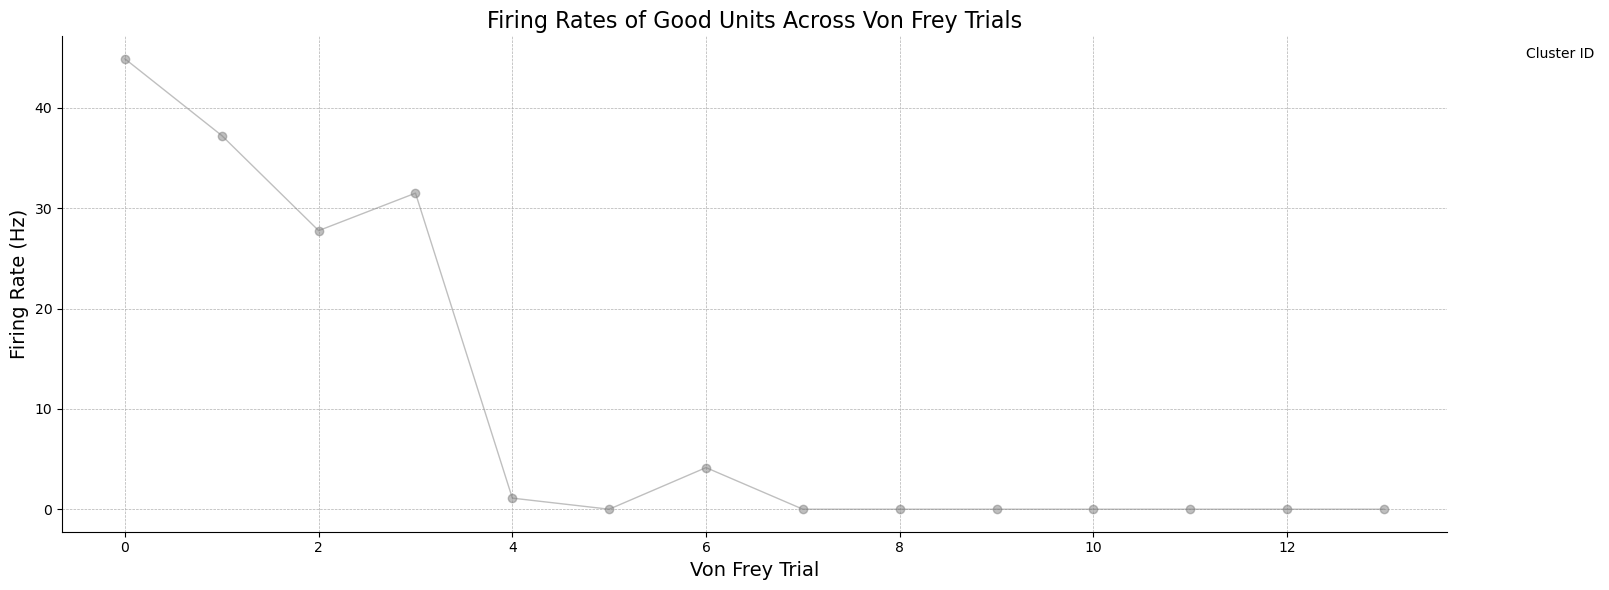

In [39]:
import matplotlib.pyplot as plt

# Assume firing_rates_df_filtered has already been computed and contains the good units

# Calculate the standard deviation for each cluster across intervals (only for filtered clusters)
std_firing_rates_filtered = firing_rates_df_filtered.std(axis=0)

# Determine a threshold for "significant change" in firing rate (using median of filtered clusters)
threshold_filtered = std_firing_rates_filtered.median()

# Identify units that show significant changes versus stable units among filtered clusters
significant_units_filtered = std_firing_rates_filtered > threshold_filtered
stable_units_filtered = ~significant_units_filtered

# Plotting only the filtered (good) clusters
plt.figure(figsize=(18, 6))

# Plot the stable units (filtered good units) with low opacity and thinner lines
for cluster in firing_rates_df_filtered.columns[stable_units_filtered]:
    plt.plot(firing_rates_df_filtered[cluster], marker='o', linestyle='-', linewidth=1, alpha=0.5, color='gray')

# Plot the significant units (filtered good units) with higher opacity and thicker lines
for cluster in firing_rates_df_filtered.columns[significant_units_filtered]:
    plt.plot(firing_rates_df_filtered[cluster], marker='o', linestyle='-', linewidth=2, alpha=0.9, label=f'Cluster {cluster}')

# Highlighting
plt.xlabel('Von Frey Trial', fontsize=14)
plt.ylabel('Firing Rate (Hz)', fontsize=14)
plt.title('Firing Rates of Good Units Across Von Frey Trials', fontsize=16)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)

# Add a legend for clusters with significant changes outside the plot
plt.legend(title='Cluster ID', bbox_to_anchor=(1.05, 1), loc='upper left', ncol=1, fontsize='small', frameon=False)

# Adjust layout to accommodate the legend outside the plot
plt.tight_layout(rect=[0, 0, 0.9, 1])  # Adjust the plot area to make space for the legend
plt.savefig(r'D:\Data\CMU.80 Data\88 Analyzed Data\88.004 Initial Analysis, DW322\figures\firing_rates_good_units.png', dpi=300, bbox_inches='tight')
plt.show()
